In [1]:
#Import Python Libraries
import pandas as pd
import pickle
import time
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')

#Import Self-written Functions
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

from d00_utils.calculateTimeDifference import calculateTimeDifference #Function to calc time difference
from d01_data.loadCommits import loadCommits #Function to load SVN data
from d02_intermediate.cleanCommitData import cleanCommitData #Function to clean commit data
from d02_intermediate.cleanJiraData import cleanJiraData #Function to clean JIRA data

from d03_processing.createFittedTF_IDF import createFittedTF_IDF #Function to see if a trace is valid
from d03_processing.createCorpusFromDocumentList import createCorpusFromDocumentList #Function to create a corpus
from d03_processing.checkValidityTrace import checkValidityTrace #Function to see if a trace is valid
from d03_processing.calculateTimeDif import calculateTimeDif #Calculate the time difference between 2 dates in seconds
from d03_processing.checkFullnameEqualsEmail import checkFullnameEqualsEmail #Check if fullName is equal to the email
from d03_processing.calculateCosineSimilarity import calculateCosineSimilarity #Calculate the cos similarity
from d03_processing.calculateDocumentStatistics import calculateUniqueWordCount
from d03_processing.calculateDocumentStatistics import calculateTotalWordCount
from d03_processing.calculateDocumentStatistics import calculateOverlapBetweenDocuments

from d04_modelling.summariseClassDistribution import summariseClassDistribution #Visualize the class distribution
from d04_modelling.showModelPerformance import showModelPerformance # Show several performance measures

#Display full value of a column
pd.set_option('display.max_colwidth', None)

#Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rande\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rande\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Load Raw Data

In [6]:
#Set dataset

datasetDirectory = ""

In [7]:
#Import raw JIRA dataset
rawData_JIRA_academy = pd.read_excel('../data/01_raw/JIRA Mendix Academy export_15_05_2021.xlsx')

#import
rawData_SVN_academy = loadCommits('../data/01_raw/academy-svn-dump.txt')

# 2. Clean Raw Data
## 2.1 Clean Raw Data - SVN Data
Clean the raw data of the SVN files

In [8]:
from datetime import datetime
import re
import pandas as pd
import string

#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import ngrams

#Function to transform natural text into unigram tokens
def preprocessNaturalLanguage(text, porterStemmer, cachedStopWords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopWords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

#Function to transform natural text into n-gram tokens
def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocessCommitDate(date_string):
    date_time_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%fZ')  
    return(date_time_obj)
    
#Remove the found Issue key from the log
def removeIssueKey(log_message):
    issue_keys = re.findall(r"LRN+.[0-9]+|AFM+.[0-9]+|MA+.[0-9]+|AFI+.[0-9]+|EM+.[0-9]+|OE+.[0-9]+|EM+.[0-9]+", log_message)
    log_message_without_key = log_message
    for issue_key in issue_keys:
        log_message_without_key = log_message_without_key.replace(issue_key, "")
    return(log_message_without_key)

def unitNamesLambdaFunc(unitName, stemmer):
    #Lower case
    unitNameLowered = unitName.lower()
    
    #Remove interpunction
    noInterpunction = unitNameLowered.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    noNumbers = ''.join([i for i in noInterpunction if not i.isdigit()])
    
    stemmendUnitName = stemmer.stem(noInterpunction)
    
    
    return(stemmendUnitName)
    

def preprocessUnitNames(unitName, porterStemmer, cachedStopWords):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #Preprocess each split found.
        unitNameLowered = list(map(lambda unitName: unitNamesLambdaFunc(unitName, porterStemmer), 
                                   unitNameSplitList))
        
        #Check for stopwords
        tokensWithoutSW = [word for word in unitNameLowered if not word in cachedStopWords]

        return(tokensWithoutSW)

def preprocessNGramsUnitNames(unitName, porterStemmer, cachedStopWords, nGramSize):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        cleanedUnitNames = []
        for unitNameSplit in unitNameSplitList:
            #Lower case unit names
            lowerCased = unitNameSplit.lower()

            #Remove interpunction
            removedInterpunction = lowerCased.translate(str.maketrans('','',string.punctuation))
            cleanedUnitNames.append(removedInterpunction)
            
        #Transform to string (needed for tokenizer
        unitNameString = ' '.join(cleanedUnitNames)

        #Tokenzize words
        tokenized = word_tokenize(unitNameString)
        
        #Create the ngrams
        ngrams = list(nltk.ngrams(tokenized, nGramSize))
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #remove all the n-grams containing a stopword
        cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
        #Stem the tokens
        stemmedNGrams = []
        for ngram in cleanNGrams:
            stemmed = list(map(porterStemmer.stem, ngram))
            stemmedNGrams.append(stemmed)
            
        return(stemmedNGrams)

#Method to clean all columns of the provided data
def cleanCommitData(rawCommitData): 
    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")
    
    #Remove all revisions without an issue key in the log message
    commit_df = rawCommitData[rawCommitData["related_issue_key"].notna()]

    #Execute cleaning methods on dataset
    cleaned_commit_logs = commit_df['log'].apply(lambda x: removeIssueKey(x))
    processed_commit_logs = cleaned_commit_logs.apply(lambda x: preprocessNaturalLanguage(x, porterStemmer, cachedStopWords))
    processed_commit_logs_2grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    processed_commit_logs_3grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    processed_date_times = commit_df['date'].apply(lambda x: preprocessCommitDate(x))
    processed_unit_names = commit_df['impacted_unit_names'].apply(lambda x: preprocessUnitNames(x, porterStemmer, cachedStopWords))
    processed_unit_names_2grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 2))
    processed_unit_names_3grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 3))
    

    #Put all data together into a new dataframe
    commit_data = {'Revision': commit_df["revision"],
               'Email' : commit_df["email"],
               'Commit_date': processed_date_times,
               "Issue_key_commit": commit_df["related_issue_key"],
               'Logs': processed_commit_logs, 
               'Logs_2grams': processed_commit_logs_2grams, 
               'Logs_3grams': processed_commit_logs_3grams, 
               'Unit_names': processed_unit_names,
               'Unit_names_2grams': processed_unit_names_2grams,
               'Unit_names_3grams': processed_unit_names_3grams,
               'Commit_natural_text': processed_commit_logs + processed_unit_names,
               'Commit_natural_text_2grams': processed_commit_logs_2grams + processed_unit_names_2grams,
               'Commit_natural_text_3grams': processed_commit_logs_3grams + processed_unit_names_3grams
               }
               
    commit_processed_df = pd.DataFrame(data=commit_data)

    return(commit_processed_df)

In [9]:
#Start timer
startTime = time.time() 

intermediateData_SVN_academy = cleanCommitData(rawData_SVN_academy)

#Create a temp XLSX file for all intermediate datasets
intermediateData_SVN_academy.to_excel(excel_writer = "../data/02_intermediate/intermediateData_SVN_academy.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_SVN_academy.to_pickle(path= "../data/02_intermediate/intermediateData_SVN_academy.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished cleaning after " + timeDifference)

Finished cleaning after 0 minutes and 16.68932318687439 seconds


In [10]:
import re

import string
#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag  import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
import numpy as np
import pandas as pd
import time
nltk.download('averaged_perceptron_tagger')


#Function to clean the comments
def clean_comments(comment):
    try:
        commentDates = re.findall(r"[0-9]{2} [A-Z][a-z]{2} [0-9]{4} [0-9]{2}:[0-9]{2};[a-zA-Z0-9_]{24};", comment)
        accountIds = re.findall(r"\[~accountid:[a-zA-Z0-9]{24}\]", comment)
               
        
        cleanedComment = comment.replace("nan",'')
        for commentDate in commentDates:
            cleanedComment = cleanedComment.replace(commentDate,'')
        
        for accountId in accountIds: 
            cleanedComment = cleanedComment.replace(accountId,'')
        
        return(cleanedComment)
    except:
        return("")

def preprocess(text, porterStemmer, cachedStopwords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopwords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocess_jira_date(date_string):
    if(isinstance(date_string, str)):
        try:
            date_time_obj = datetime.strptime(date_string, '%d %b %Y %H:%M')
        except:
            date_time_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S:%f')
        return(date_time_obj)
    elif(isinstance(date_string, datetime)): 
        return(date_string)
    else:
        return(np.nan)
    
    
def findVerbs(tokenList):
    posTags = pos_tag(tokenList)
    verbAbrList = ['VBP', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS']
    verbList = []
    for posTag in posTags:
        if posTag[1] in verbAbrList:
            verbList.append(posTag[0])
    return(verbList)

#Preprocess all the features and transform to the format needed for further processing.
def preprocessJiraData(cleanDataFrame, preprocessComments, porterStemmer, cachedStopWords, startTime):
    if (preprocessComments == True):
        nOfSteps = '4'
    else:
        nOfSteps = '3'

    #preprocess Summaries
    jira_summaries = cleanDataFrame['Summary'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_summaries_2grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_summaries_3grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    
    endTimeCleaningSummaries = time.time() - startTime
    print("1/" + nOfSteps + ") Finished Cleaning Summaries after " + str(endTimeCleaningSummaries) + " sec")

    #preprocess Descriptions
    jira_descriptions = cleanDataFrame['Description'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_descriptions_2grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_descriptions_3grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    
    endTimeCleaningDescriptions = time.time() - startTime
    print("2/" + nOfSteps + ") Finished Cleaning Description after " + str(endTimeCleaningDescriptions) + " sec")

    #preprocess Dates
    jira_creation = cleanDataFrame['Created'].apply(lambda x: preprocess_jira_date(x))
    jira_updated = cleanDataFrame['Updated'].apply(lambda x: preprocess_jira_date(x))
    jira_resolved = cleanDataFrame['Resolved'].apply(lambda x: preprocess_jira_date(x))
    endTimeCleaningDates = time.time() - startTime
    print("3/" + nOfSteps + ") Finished Cleaning Dates after " + str(endTimeCleaningDates) + " sec")

    #Comments take too long for a test run.
    if (preprocessComments == True):
        jira_comments = cleanDataFrame['Comments'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
        jira_comments_2grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        jira_comments_3grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        endTimeCleaningComments = time.time() - startTime
        print("4/" + nOfSteps + ") Finished Cleaning Comments after " + str(endTimeCleaningComments) + " sec")

         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries, 
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams, 
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Comments': jira_comments,
             'Comments_2grams': jira_comments_2grams,
             'Comments_3grams': jira_comments_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions + jira_comments,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams + jira_comments_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams + jira_comments_3grams}
    else:
         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries,
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams,
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams}

    jira_processed_df = pd.DataFrame(data=jira_data)
    
    #Find verbs
    jira_processed_df['verbs'] = jira_processed_df['Jira_natural_text'].apply(lambda x: findVerbs(x))
    
    return(jira_processed_df)

#Input dataframe and num of_comments, and bool to determine if comments need to be cleaned
def cleanJiraData(dataFrame, cleanComments, commentAmount):
    startTime = time.time()

    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")

    if (cleanComments == True):
        #Subset only all comments 
        loc_first_comment = dataFrame.columns.get_loc('Comment') # Variable storing the col location of the 1st comment
    
        dataFrame["Comments"] = dataFrame.iloc[:,loc_first_comment:loc_first_comment+commentAmount].apply(
            lambda x: " ".join(x.astype(str)), axis=1)
    
        #First remove the date and comment string from the comments
        dataFrame["Comments"] = dataFrame["Comments"].apply(lambda x: clean_comments(x))

        #Subset JIRA ID, Summary, Description, comments
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Comments", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = True, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)
    else: 
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = False, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rande\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
#Rename key to Issue key
rawData_JIRA_academy = rawData_JIRA_academy.rename({'Key': 'Issue key'}, axis=1)

#Clean Data sets
intermediateData_JIRA_academy = cleanJiraData(dataFrame = rawData_JIRA_academy, cleanComments = False, commentAmount = 39)

#Create a temp XLSX file for all intermediate datasets
intermediateData_JIRA_academy.to_excel(excel_writer = "../data/02_intermediate/intermediateData_JIRA_academy.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_JIRA_academy.to_pickle(path= "../data/02_intermediate/intermediateData_JIRA_academy.pkl")

1/3) Finished Cleaning Summaries after 0.8327536582946777 sec
2/3) Finished Cleaning Description after 8.674210786819458 sec
3/3) Finished Cleaning Dates after 8.684303998947144 sec


## 2.4 Clean Raw Data - Create JIRA Corpora
Create the corpora for JIRA UNIGRAM

In [12]:
def createCorpusFromDocumentList(token_column):
    token_list = token_column.tolist()
    corpus_list = []
    
    for document in token_list:
        #Only join to the string when a list. When it is not a list, then it is np.NaN, thus no changes
        if(isinstance(document, list)):
            #Transform list to a string for SKLEARN to accept the input.
            token_string = ' '.join(document)
        
            #Add string to the corpus list
            corpus_list.append(token_string)
    return(corpus_list)

In [13]:
#Create JIRA corpus for academy dataset
intermediateData_JIRA_academyCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_academy.Summary)
intermediateData_JIRA_academyCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_academy.Description)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_academyCorpus = [i+" "+j for i,j in zip(intermediateData_JIRA_academyCorpusSummary,
                                                                             intermediateData_JIRA_academyCorpusDescription
                                                                            )]

#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_academyCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_academyCorpus, f)

Bigram corpora

In [14]:
def createCorpusNGrams(tokenColumn):
    tokenList = tokenColumn.tolist()
    corpusList = []
    
    #Transform to strings
    for document in tokenList:
        if(isinstance(document, list)):
            for ngram in document:
                ngramString = ' '.join(ngram)
                corpusList.append(ngramString)         
    return(corpusList)

In [15]:
#Create JIRA corpus for academy dataset
intermediateData_JIRA_academyCorpusSummary_2grams = createCorpusNGrams(intermediateData_JIRA_academy.Summary_2grams)
intermediateData_JIRA_academyCorpusDescription_2grams = createCorpusNGrams(intermediateData_JIRA_academy.Description_2grams)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_academyCorpus_2gram = [i+" "+j for i,j in zip(intermediateData_JIRA_academyCorpusSummary_2grams,
                                                                             intermediateData_JIRA_academyCorpusDescription_2grams
                                                                             )]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_academyCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_academyCorpus_2gram, f)

## 2.4 Clean Raw Data - Create SVN Corpora
Create the corpora for SVN

In [16]:
intermediateData_SVN_academy = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_academy.pkl")

In [17]:
#Create corpus for log messages
intermediateData_SVNLogs_academyCorpus = createCorpusFromDocumentList(intermediateData_SVN_academy.Logs)

#Create corpus for unit names
intermediateData_SVNUnitNames_academyCorpus = createCorpusFromDocumentList(intermediateData_SVN_academy.Unit_names)

#Create corpus for entire commit (log message + model)
intermediateData_SVN_academyCorpus = createCorpusFromDocumentList(intermediateData_SVN_academy.Logs + intermediateData_SVN_academy.Unit_names)
intermediateData_SVN_academyCorpusAll = createCorpusFromDocumentList(intermediateData_SVN_academy.Logs + intermediateData_SVN_academy.Unit_names)
#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_SVNLogs_academyCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_academyCorpus, f)

with open('../data/02_intermediate/intermediateData_SVNUnitNames_academyCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_academyCorpus, f)

with open('../data/02_intermediate/intermediateData_SVN_academyCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_academyCorpus, f)
    
with open('../data/02_intermediate/intermediateData_SVN_academyCorpusAll.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_academyCorpusAll, f)

bigram corpora

In [18]:
intermediateData_SVNLogs_academyCorpus_2gram = createCorpusNGrams(intermediateData_SVN_academy.Logs_2grams)
intermediateData_SVNUnitNames_academyCorpus_2gram = createCorpusNGrams(intermediateData_SVN_academy.Unit_names_2grams)
with open('../data/02_intermediate/intermediateData_SVNLogs_academyCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_academyCorpus_2gram, f)
    
    
with open('../data/02_intermediate/intermediateData_SVNUnitNames_academyCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_academyCorpus_2gram, f)

# 3. Preprocess Data

In [19]:
#Run this code block when you've restarted the kernel, and want to use previously gained results.
intermediateData_JIRA_academy = pd.read_pickle("../data/02_intermediate/intermediateData_JIRA_academy.pkl")

intermediateData_SVN_academy = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_academy.pkl")

intermediateData_JIRA_academyCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_academyCorpus.pkl')
intermediateData_JIRA_academyCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_academyCorpus.pkl')
#intermediateData_SVN_academyCorpusAll = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_academyCorpusAll.pkl')
#intermediateData_SVN_academyCorpusModel = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_academyCorpusModel.pkl')
intermediateData_SVN_academyCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_academyCorpus.pkl')

############# Bigrams


############# Trigrams

## 3.0 Preprocess Data - Create cartesian product JIRA x Commits

In [20]:
intermediateData_SVN_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")

#Create cartesian products JIRA x Commits
processedData_academyCartesian = intermediateData_JIRA_academy.merge(intermediateData_SVN_academy, how='cross')

processedData_academyCartesian = processedData_academyCartesian.drop(processedData_academyCartesian[processedData_academyCartesian.Jira_created_date > processedData_academyCartesian.Commit_date].index)

#Create a pickle file for all intermediate datasets
processedData_academyCartesian.to_pickle(path= "../data/03_processed/processedData_academyCartesian.pkl")


In [21]:
processedData_academyCartesian.head()

,Issue_key_jira,Assignee,Jira_created_date,Jira_updated_date,Jira_resolved_date,Summary,Summary_2grams,Summary_3grams,Description,Description_2grams,Description_3grams,Jira_natural_text,Jira_natural_text_2grams,Jira_natural_text_3grams,verbs,Revision,Email,Commit_date,Issue_key_commit,Logs,Logs_2grams,Logs_3grams,Unit_names,Unit_names_2grams,Unit_names_3grams,Commit_natural_text,Commit_natural_text_2grams,Commit_natural_text_3grams
138947,LRN-1198,Jasmine Vyas,2021-03-29 14:50:08.502,2021-04-16 10:00:43.182,2021-04-16 10:00:43.178,"[academi, v]","[[academi, v]]",[],"[constant, constantvalueaddit, inform, schedul, event, none, migrat, none, special, action, colorbd, releas, color, colorb, done, color, datalak, data, produc, remov, tabl, schema, ’, reappli, via, way, data, clean, datalak, valid, databas, viewer, tool, product, tabl, longer, data, insid, tabl, colorfff, releas, color, knowledg, api, stori, assign, releas, reassign, user, certif, certif, api, sinc, chang, order, set, associ, certif, metadata, done, admin, panel, →, dashboard, button, action, first, remov, assign, certif, user, appli, colorfff, releas, color, httpsmendixatlassiannetbrowselrnhttpsmendixatlassiannetbrowselrnsmartlinkhttpsmendixatlassiannetbrowselrnhttpsmendixatlassiannetbrowselrnsmartlinksmartlink, creat, intermedi, exam, page, admin, panel, past, text, found, provid, intermedi, document, easier, text, assign, test, environ, intermedi, exam, also, chang, advanc, develop, exam, ...]","[[constant, constantvalueaddit], [constantvalueaddit, inform], [inform, schedul], [schedul, event], [event, none], [none, migrat], [migrat, none], [special, action], [action, colorbd], [releas, color], [color, colorb], [colorb, done], [done, color], [color, datalak], [datalak, data], [data, produc], [produc, remov], [schema, ’], [datalak, valid], [databas, viewer], [viewer, tool], [product, tabl], [longer, data], [data, insid], [tabl, colorfff], [releas, color], [color, knowledg], [knowledg, api], [api, stori], [releas, reassign], [certif, api], [api, sinc], [admin, panel], [panel, →], [→, dashboard], [first, remov], [assign, certif], [releas, color], [color, httpsmendixatlassiannetbrowselrnhttpsmendixatlassiannetbrowselrnsmartlinkhttpsmendixatlassiannetbrowselrnhttpsmendixatlassiannetbrowselrnsmartlinksmartlink], [httpsmendixatlassiannetbrowselrnhttpsmendixatlassiannetbrowselrnsmartlinkhttpsmendixatlassiannetbrowselrnhttpsmendixatlassiannetbrowselrnsmartlinksmartlink, creat], [intermedi, exam], [exam, page], [admin, panel], [provid, intermedi], [intermedi, document], [test, environ], [intermedi, exam], [exam, also], [also, chang], [advanc, develop], [develop, exam], [exam, classroom], [admin, panel], [section, prerequis], [rapid, develop], [develop, certif], [intermedi, develop], [develop, certif], [certif, colorfff], [releas, color], [color, jasmin], [jasmin, httpsmendixatlassiannetbrowselrnhttpsmendixatlassiannetbrowselrnsmartlinkhttpsmendixatlassiannetbrowselrnhttpsmendixatlassiannetbrowselrnsmartlinksmartlink], [httpsmendixatlassiannetbrowselrnhttpsmendixatlassiannetbrowselrnsmartlinkhttpsmendixatlassiannetbrowselrnhttpsmendixatlassiannetbrowselrnsmartlinksmartlink, go], [admin, panel], [duplic, record], [record, tab], [manual, trigger], [fix, duplic], [duplic, record], [record, button], [tab, learn], [learn, path], [path, none], [none, modul], [modul, lectur], [learningpath, version], [version, draft], [draft, modul], [modul, version], [version, lectur], [lectur, version], [version, also], [duplic, lecturevers], [lecturevers, object], [fix, duplic], [duplic, button], [test, plan], [plan, test], [httpspaperdropboxcomdocreleasetestplanacademyvbigzjplffhrxibzukzagoqxjvavqlsbfcacvubhttpspaperdropboxcomdocreleasetestplanacademyvbigzjplffhrxibzukzagoqxjvavqlsbfcacvub, day], [releas, statusstepsresult], [statusstepsresult, comment], [comment, xcheck], [releas, checklist], [checklist, check], [relat, stori], [jira, releas], [releas, listhttpsmendixatlassiannetprojectslrnve

## 3.1 Preprocess Data - Create Labels

In [31]:
#Create new dataFrames for the time features
processedData_academyLabels = pd.DataFrame() 


#Create a column, which indicates which traces are valid.
processedData_academyLabels["is_valid"] = processedData_academyCartesian.apply(lambda x: checkValidityTrace(x.Issue_key_jira, x.Issue_key_commit), axis=1)
print("Finished creating labels for academy")

#Save intermediate results
processedData_academyLabels.to_pickle(path= "../data/03_processed/processedData_academyLabels.pkl")

processedData_academyLabels.info()

Finished creating labels for academy
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1375042 entries, 138947 to 3139051
Data columns (total 1 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   is_valid  1375042 non-null  bool 
dtypes: bool(1)
memory usage: 11.8 MB


In [32]:
#processedData_academyLabels[processedData_academyLabels.is_valid == True].count()
processedData_academyLabels[processedData_academyLabels.is_valid == True].count()

is_valid    3104
dtype: int64

## 3.2 Preprocess Data - Create Time-Related Features

In [20]:
#Create new dataFrames for the time features
processedData_academyFeaturesTime = pd.DataFrame() 


#Calculate the time features for data Processing Dataset
processedData_academyFeaturesTime['Creation_commit_date_dif'] = processedData_academyCartesian.apply(lambda x: calculateTimeDif(x.Jira_created_date, x.Commit_date), axis=1)
processedData_academyFeaturesTime['Updated_commit_date_dif'] = processedData_academyCartesian.apply(lambda x: calculateTimeDif(x.Jira_updated_date, x.Commit_date), axis=1)
processedData_academyFeaturesTime['Resolved_commit_date_dif'] = processedData_academyCartesian.apply(lambda x: calculateTimeDif(x.Jira_resolved_date, x.Commit_date), axis=1)
print("Finished data Processing")

#Create a pickle file for all intermediate datasets
processedData_academyFeaturesTime.to_pickle(path= "../data/03_processed/processedData_academyFeaturesTime.pkl")

Finished data Processing


## 3.3 Preprocess Data - Create Stakeholder-Related Features

In [21]:
#Create new dataFrames for the Stakeholder features
processedData_academyFeaturesStakeholder = pd.DataFrame() 

processedData_academyFeaturesStakeholder['Assignee_is_commiter'] = processedData_academyCartesian.apply(lambda x: checkFullnameEqualsEmail(x.Assignee, x.Email), axis=1)
print("Finished academy")

#Create a pickle file for all intermediate datasets
processedData_academyFeaturesStakeholder.to_pickle(path= "../data/03_processed/processedData_academyFeaturesStakeholder.pkl")


Finished academy


In [22]:
processedData_academyFeaturesStakeholder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1375042 entries, 138947 to 3139051
Data columns (total 1 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Assignee_is_commiter  381844 non-null  float64
dtypes: float64(1)
memory usage: 21.0 MB


## 3.4 Preprocess Data - Create Cosine Similarity Features
### 3.4.1 academy - Cosine Similarity UniGrams

In [33]:
from scipy import spatial
import pandas as pd

def calc_vector_representation(document, cv, fittedTF_IDF):        
    #Transform document type to a string
    documentString = document
    
    #Calculate the Term Frequency of the document
    inputDocs = [documentString] 

    # count matrix 
    count_vector = cv.transform(inputDocs) 
 
    #tf-idf scores 
    tf_idf_vector = fittedTF_IDF.transform(count_vector)

    feature_names = cv.get_feature_names() 
 
    #get tfidf vector for first document 
    document_vector=tf_idf_vector[0] 
 
    #print the scores 
    
    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
    df.sort_values(by=["tfidf"],ascending=False)

    return(document_vector.T.todense())

def calculateCosineSimilarity(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)

def calculateCosineSimilarityNGrams(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)


def calculateCosineSimilarityWithPOSPruning(document1, document2, cv, fittedTF_IDF, verbList):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    verbCounter = 0
    if(isinstance(document2, list)):
        for token in document2:
            if token in verbList:
                verbCounter = verbCounter + 1
    
    if verbCounter > 0:
        result = result * (1 + (0.1 * verbCounter))
    else:
        result = 0
    
    return(result)

In [22]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 

######################################################
#                       academy              #
######################################################

################# Unigrams ###############
#instantiate CountVectorizer() for SVN
processedData_SVN_academyCountVectorizer = CountVectorizer()
processedData_SVN_academyCountTF_IDF = createFittedTF_IDF(processedData_SVN_academyCountVectorizer, intermediateData_SVN_academyCorpus)

processedData_SVNLogs_academyCountVectorizer = CountVectorizer()
processedData_SVNLogs_academyCountTF_IDF = createFittedTF_IDF(processedData_SVNLogs_academyCountVectorizer, intermediateData_SVNLogs_academyCorpus)

processedData_SVNUnitNames_academyCountVectorizer = CountVectorizer()
processedData_SVNUnitNames_academyCountTF_IDF = createFittedTF_IDF(processedData_SVNUnitNames_academyCountVectorizer, intermediateData_SVNUnitNames_academyCorpus)

#instantiate CountVectorizer() for JIRA - unigram
processedData_JIRA_academyCountVectorizer = CountVectorizer()
processedData_JIRA_academyCountTF_IDF = createFittedTF_IDF(processedData_JIRA_academyCountVectorizer, intermediateData_JIRA_academyCorpus)

processedData_JIRASummaries_academyCountVectorizer = CountVectorizer()
processedData_JIRASummaries_academyCountTF_IDF = createFittedTF_IDF(processedData_JIRASummaries_academyCountVectorizer, intermediateData_JIRA_academyCorpusSummary)

processedData_JIRADescriptions_academyCountVectorizer = CountVectorizer()
processedData_JIRADescriptions_academyCountTF_IDF = createFittedTF_IDF(processedData_JIRADescriptions_academyCountVectorizer, intermediateData_JIRA_academyCorpusDescription)

#processedData_JIRAComments_academyCountVectorizer = CountVectorizer()
#processedData_JIRAComments_academyCountTF_IDF = createFittedTF_IDF(processedData_JIRAComments_academyCountVectorizer, intermediateData_JIRA_academyCorpusComments)


################# Bigrams ###############
#instantiate CountVectorizer() for SVN - bigrams
processedData_SVNLogs_academyCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_SVNLogs_academyCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNLogs_academyCountVectorizer_2gram, intermediateData_SVNLogs_academyCorpus_2gram)

processedData_SVNUnitNames_academyCountVectorizer_2gram = CountVectorizer()
processedData_SVNUnitNames_academyCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNUnitNames_academyCountVectorizer_2gram, intermediateData_SVNUnitNames_academyCorpus_2gram)


#instantiate CountVectorizer() for JIRA - biigram
processedData_JIRA_academyCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRA_academyCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRA_academyCountVectorizer_2gram, intermediateData_JIRA_academyCorpus_2gram)

processedData_JIRASummaries_academyCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRASummaries_academyCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRASummaries_academyCountVectorizer_2gram, intermediateData_JIRA_academyCorpusSummary_2grams)

processedData_JIRADescriptions_academyCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRADescriptions_academyCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRADescriptions_academyCountVectorizer_2gram, intermediateData_JIRA_academyCorpusDescription_2grams)

#processedData_JIRAComments_academyCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
#processedData_JIRAComments_academyCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRAComments_academyCountVectorizer_2gram, intermediateData_JIRA_academyCorpusComments_2grams)




#### 3.4.1 [VSM unigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [25]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmLogsJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmLogsJiraAsQuery["vsm_logs_jira_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_academyCountVectorizer, processedData_JIRA_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmLogsJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmLogsJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\spatial\distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Finished creating 'VSM Logs Jira as query' after 171 minutes and 4.538911581039429 seconds


#### 3.4.2 [VSM unigram] Similarity between JIRA issue and Commit Log - Log As Query

In [26]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmLogsLogAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmLogsLogAsQuery["vsm_logs_log_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_academyCountVectorizer, processedData_SVNLogs_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmLogsLogAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmLogsLogAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 129 minutes and 54.4845917224884 seconds


#### 3.4.3 [VSM unigram] Similarity between JIRA issue and Unit Names - JIRA As Query

In [27]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmUnitNamesJiraAsQuery["vsm_unit_names_jira_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_academyCountVectorizer, processedData_JIRA_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 162 minutes and 42.55891966819763 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Jira As Query

In [28]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmSummaryLogsSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmSummaryLogsSummaryAsQuery["vsm_summary_logs_summary_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_JIRASummaries_academyCountVectorizer, processedData_JIRASummaries_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmSummaryLogsSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmSummaryLogsSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 82 minutes and 24.53457760810852 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Log As Query

In [29]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmSummaryLogsLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmSummaryLogsLogsAsQuery["vsm_summary_logs_logs_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_SVNLogs_academyCountVectorizer, processedData_SVNLogs_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmSummaryLogsLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmSummaryLogsLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 127 minutes and 20.38952612876892 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - Summary As Query

In [30]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmSummaryUnitNamesSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmSummaryUnitNamesSummaryAsQuery["vsm_summary_unitNames_summary_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_JIRASummaries_academyCountVectorizer, processedData_JIRASummaries_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmSummaryUnitNamesSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 600 minutes and 4.616283893585205 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - UnitNames As Query

In [31]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmSummaryUnitNamesUnitNamesAsQuery["vsm_summary_unitNames_unitNames_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_SVNUnitNames_academyCountVectorizer, processedData_SVNUnitNames_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 81 minutes and 34.31193780899048 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names - JIRA As Query

In [32]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmVerbPruningUnitNamesJiraAsQuery["vsm_verb_pruning_unit_names_jira_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_JIRA_academyCountVectorizer, processedData_JIRA_academyCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmVerbPruningUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query and verb pruning' after " + timeDifference)

Finished creating 'VSM Logs Jira as query and verb pruning' after 163 minutes and 27.66766881942749 seconds


#### 3.4.4 [VSM unigram] Similarity between JIRA issue and Unit Names  - Unit Names As Query

In [33]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmUnitNamesUnitNamesAsQuery["vsm_unit_names_log_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_academyCountVectorizer, processedData_SVNUnitNames_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 81 minutes and 58.37825131416321 seconds


#### 3.4.5 [VSM unigram] Similarity between JIRA description and commit log - Description as query

In [34]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmDescriptionDescriptionAsQuery["vsm_description_description_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_academyCountVectorizer, processedData_JIRADescriptions_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 161 minutes and 51.17785954475403 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as descrintion

In [35]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmDescriptionLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmDescriptionLogsAsQuery["vsm_description_log_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_academyCountVectorizer, processedData_SVNUnitNames_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmDescriptionLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmDescriptionLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 81 minutes and 36.3745481967926 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

#### 3.4.5 [VSM unigram Silarity between JIRA Comment and commit log - Comment as description

#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as description

#### [VSM bigram] Similarity between JIRA comments and Commit Logs - Logs as query

#### 3.4.5 [VSM bigram] Silarity between JIRA Comment and commit log - Comment as query

#### [VSM Unigram] Similarity between Unit Names and Description - Unit Names as query

In [36]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmUnitNamesDescriptionUnitNamesAsQuery["vsm_unitnames_description_unitnames_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_academyCountVectorizer, processedData_SVNUnitNames_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmUnitNamesDescriptionUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 81 minutes and 50.44815397262573 seconds


#### [VSM Unigram] Similarity between Unit Names and Description - Description as query

In [37]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmUnitNamesDescriptionDescriptionAsQuery["vsm_unitnames_description_description_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_JIRADescriptions_academyCountVectorizer, processedData_JIRADescriptions_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmUnitNamesDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 752 minutes and 27.15877938270569 seconds


#### [VSM Unigram] Similarity between Unit Names and Comments - Unit Names as query

#### [VSM Unigram] Similarity between Unit Names and Comments - Comments as query

In [38]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely)- JIRA as query

In [39]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmSvnJiraJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmSvnJiraJiraAsQuery["vsm_svn_jira_jira_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_JIRA_academyCountVectorizer, processedData_JIRA_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmSvnJiraJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmSvnJiraJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 163 minutes and 44.769426107406616 seconds


In [40]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely) - SVN as query

In [41]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmSvnJiraSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmSvnJiraSvnAsQuery["vsm_svn_jira_svn_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_academyCountVectorizer, processedData_SVN_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmSvnJiraSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmSvnJiraSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 133 minutes and 49.20695185661316 seconds


In [42]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - SVN as query

In [43]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmSvnSummarySvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmSvnSummarySvnAsQuery["vsm_svn_summary_svn_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_SVN_academyCountVectorizer, processedData_SVN_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmSvnSummarySvnAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmSvnSummarySvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 131 minutes and 49.182390451431274 seconds


In [44]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - Summary as query

In [45]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmSvnSummarySummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmSvnSummarySummaryAsQuery["vsm_svn_summary_summary_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_JIRASummaries_academyCountVectorizer, processedData_JIRASummaries_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmSvnSummarySummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmSvnSummarySummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 83 minutes and 56.17693471908569 seconds


In [46]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - SVN as query

In [47]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmSvnDescriptionSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmSvnDescriptionSvnAsQuery["vsm_svn_description_svn_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_SVN_academyCountVectorizer, processedData_SVN_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmSvnDescriptionSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmSvnDescriptionSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 132 minutes and 2.7590341567993164 seconds


In [48]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - Description as query

In [49]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmSvnDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmSvnDescriptionDescriptionAsQuery["vsm_svn_description_description_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_JIRADescriptions_academyCountVectorizer, processedData_JIRADescriptions_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmSvnDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmSvnDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 161 minutes and 10.981512308120728 seconds


In [50]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - SVN as query

In [51]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - Comments as query

#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names and verb pruning - Unit Names As Query

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmVerbPruningUnitNamesUnitNamesAsQuery["vsm_verb_pruning_unit_names_log_as_query"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_academyCountVectorizer, processedData_SVNUnitNames_academyCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

#### 3.4.5 [VSM bigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmLogsJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmLogsJiraAsQuery_2gram["vsm_logs_jira_as_query_2gram"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_academyCountVectorizer_2gram, processedData_JIRA_academyCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmLogsJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmLogsJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Commit Log - Logs As Query

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmLogsLogAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmLogsLogAsQuery_2gram["vsm_logs_log_as_query_2gram"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_academyCountVectorizer_2gram, processedData_SVNLogs_academyCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmLogsLogAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmLogsLogAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - Jira As Query

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmUnitNamesJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmUnitNamesJiraAsQuery_2gram["vsm_unit_names_jira_as_query_2gram"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_academyCountVectorizer_2gram, processedData_JIRA_academyCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmUnitNamesJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmUnitNamesJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - UnitNames As Query

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmUnitNamesUnitNamesAsQuery_2gram["vsm_unit_names_log_as_query_2gram"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_academyCountVectorizer_2gram, processedData_SVNUnitNames_academyCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmUnitNamesUnitNamesAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

#### [VSM bigram] Similarity between Logs and Description - Logs as Query

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmDescriptionLogsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmDescriptionLogsAsQuery_2gram["vsm_description_log_as_query_2gram"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_academyCountVectorizer_2gram, processedData_SVNUnitNames_academyCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmDescriptionLogsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmDescriptionLogsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

#### [VSM bigram] Similarity between Logs and Description - Description as Query

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmDescriptionDescriptionAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmDescriptionDescriptionAsQuery_2gram["vsm_description_description_as_query_2gram"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_academyCountVectorizer_2gram, processedData_JIRADescriptions_academyCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmDescriptionDescriptionAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmDescriptionDescriptionAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Bigrams' after " + timeDifference)

#### [VSM bigram] Similarity between Logs and Summary - Logs as Query

#### [VSM bigram] Similarity between Logs and Summary - Summary as Query

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academy_features_VsmSummaryLogsSummaryAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academy_features_VsmSummaryLogsSummaryAsQuery_2gram["vsm_summary_logs_summary_as_query_2gram"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarityNGrams(x.Summary, x.Logs, processedData_JIRASummaries_academyCountVectorizer_2gram, processedData_JIRASummaries_academyCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_academy_features_VsmSummaryLogsSummaryAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_academy_features_VsmSummaryLogsSummaryAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

## 3.6 Document Statistics

### academy

In [20]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_academyFeaturesUniqueWordCount = pd.DataFrame() 
processedData_SVN_academyFeaturesUniqueWordCount = pd.DataFrame() 
processedData_JIRA_academyFeaturesTotalWordCount = pd.DataFrame() 
processedData_SVN_academyFeaturesTotalWordCount = pd.DataFrame()

processedData_JIRA_academyFeaturesOverlapPercentage = pd.DataFrame()
processedData_SVN_academyFeaturesOverlapPercentage = pd.DataFrame()
processedData_UNION_academyFeaturesOverlapPercentage = pd.DataFrame()

#Calculate unique terms JIRA for each trace
processedData_JIRA_academyFeaturesUniqueWordCount["unique_term_count_jira"] = processedData_academyCartesian.apply(lambda x: calculateUniqueWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate unique terms JIRA for each trace
processedData_SVN_academyFeaturesUniqueWordCount["unique_term_count_svn"] = processedData_academyCartesian.apply(lambda x: calculateUniqueWordCount(x.Commit_natural_text), 
                                                            axis=1)

#Calculate total terms JIRA for each trace
processedData_JIRA_academyFeaturesTotalWordCount["total_term_count_jira"] = processedData_academyCartesian.apply(lambda x: calculateTotalWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate total terms JIRA for each trace
processedData_SVN_academyFeaturesTotalWordCount["total_term_count_svn"] = processedData_academyCartesian.apply(lambda x: calculateTotalWordCount(x.Commit_natural_text), 
                                                            axis=1)

processedData_JIRA_academyFeaturesOverlapPercentage["overlap_percentage_compared_to_jira"] = processedData_academyCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list1'),
                                                            axis=1)
processedData_SVN_academyFeaturesOverlapPercentage["overlap_percentage_compared_to_svn"] = processedData_academyCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list2'),
                                                            axis=1)
processedData_UNION_academyFeaturesOverlapPercentage["overlap_percentage_compared_to_union"] = processedData_academyCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'union'),
                                                            axis=1)





#Save results in pickle
processedData_JIRA_academyFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesUniqueWordCount.pkl")
processedData_SVN_academyFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesUniqueWordCount.pkl")
processedData_JIRA_academyFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesTotalWordCount.pkl")
processedData_SVN_academyFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesTotalWordCount.pkl")

processedData_JIRA_academyFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesOverlapPercentage.pkl")
processedData_SVN_academyFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesOverlapPercentage.pkl")
processedData_UNION_academyFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_UNION_academyFeaturesOverlapPercentage.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating document statistics in " + timeDifference)

Finished creating document statistics in 4 minutes and 42.6787588596344 seconds


## 3.7 Query Quality

In [23]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from statistics import mean, median, mode, stdev, variance
from math import log, sqrt
import itertools

#Function calculating the IDFs of all query terms. Returns a list containing all IDFs
def calcIDFList(document, cv, tfidf_transformer):
    idfScoreList=[]
    if isinstance(document, list):
        termCount = len(document)
        for term in document:
            try:
                indexOfWord = cv.get_feature_names().index(term)
                idfScore = tfidf_transformer.idf_[indexOfWord]
                idfScoreList.append(idfScore)
            except:
                idfScoreList.append(0)
    else:
        termCount = 0
    return(idfScoreList)


def calcAvgIDF(IDFList):
    termCount = len(IDFList)
    if(termCount != 0):
        avgIdf = sum(IDFList) / termCount
    else:
        avgIdf = 0
    return(avgIdf)

def calcMaxIDF(IDFList): 
    termCount = len(IDFList)
    if(termCount != 0):
        maxIdf = np.amax(IDFList)
    else: 
        maxIdf = 0
    return(maxIdf)

def calcDevIDF(IDFList):
    termCount = len(IDFList)
    if(termCount > 1):
        stdevIdf = stdev(IDFList)
    else: 
        stdevIdf = 0
    return(stdevIdf)

#Function calculating the ICTF of all query terms. Returns a list containing all IDFs
def calcICTFList(document, cv, documentCount):
    ICTFList = []
        #For all terms in query, find how often they occur in the Corpus
    if isinstance(document, list):
        for term in document:
            try:
            #Find out how often the term occurs in the corpus
                termFrequency = (cv.vocabulary_[term])
                
                #Compute the log
                ictF = log(documentCount/termFrequency)
            except:
                ictF = 0
            
            ICTFList.append(ictF)
    return(ICTFList)

def calcAvgICTF(ICTFList, documentCount):
    avgICTF = sum(ICTFList) / documentCount
    return(avgICTF)


def calcMaxICTF(ICTFList): 
    termCount = len(ICTFList)
    if(termCount != 0):
        maxICTF = np.amax(ICTFList)
    else: 
        maxICTF = 0
    return(maxICTF)

def calcDevICTF(ICTFList):
    termCount = len(ICTFList)
    if(termCount > 1):
        stdevICTF = stdev(ICTFList)
    else: 
        stdevICTF = 0
    return(stdevICTF)


def calcEntropyList(query, cv, documentCount, docCollection):
    #entropy(t) = ∑ (d∈Dt)  ( tf(t,d) / tf(t, D) ) * log |D|(tf(t,d) / tf(t, D) )
        
    entropyValueList = []
    #for each term in the query, calculate the entropy of the query
    if isinstance(query, list):
        for queryTerm in query:
            #For each d ∈ D
            
            partialEntropyList = []
            
            for d in docCollection:
                #Check if queryTerm occurs in D (i.e/ d∈Dt)
                if (isinstance(d, list)):
                    if queryTerm in d:
                        try:
                            #Calculate the frequency of the term occurs in the document (i.e tf(t,d))
                            queryTermFrequencyInDocument = d.count(queryTerm)
                            
                            #calculate the frequency the term occurs in the query corpus (i.e tf(t,D))
                            queryTermFrequencyInCorpus = (cv.vocabulary_[queryTerm])
                             
                            # This part of the calculation tf(t,d) / tf(t, D)  * log |D|(tf(t,d) / tf(t, D))
                            partialEntropy1stHalf = queryTermFrequencyInDocument / queryTermFrequencyInCorpus
                            partialEntropy2ndHalf = log((queryTermFrequencyInDocument / queryTermFrequencyInCorpus), documentCount)
                            partialEntropy = partialEntropy1stHalf
                            partialEntropyList.append(partialEntropy)
                        except:
                            partialEntropyList.append(0) #If term not found entropy is 0
            #this part of the calculation ∑ (d∈Dt)
            entropyValueOfQueryTerm = sum(partialEntropyList)
            entropyValueList.append(entropyValueOfQueryTerm)
    
    return(entropyValueList)


def calcAvgEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        avgEntropy = sum(entropyValueList) / len(entropyValueList)
    else:
        avgEntropy = 0
    return(avgEntropy)

    
def calcMedEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        medEntropy = median(entropyValueList)
    else:
        medEntropy = 0
    return(medEntropy)
    
def calcMaxEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        maxEntropy = np.amax(entropyValueList)
    else: 
        maxEntropy = 0
    return(maxEntropy)
    
def calcDevEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount > 1):
        #Calculate the average of all the entropies
        devEntropy = stdev(entropyValueList)
    else:
        devEntropy = 0
    return(devEntropy)

#The percentage of documents in the collection containing at least one of the query terms
def calcQueryScope(query, docCollection): 
    counter = 0
    if isinstance(query, list):
        for document in docCollection:
            #check if query occurs in term. 
            if(isinstance(document, list)):
                for queryTerm in query:
                    if queryTerm in document:
                        counter = counter + 1
                        break
    queryScope = counter / len(docCollection)
    return(queryScope)

#The Kullback-Leiber divergence of the query language model from the collection language model
def calcSCS(query, cv, docCount):
    divergenceList = []
    if isinstance(query, list):
        for queryTerm in query:
            try:
                #frequency of term in query - tf(q, Q)/|Q|
                pqQ = query.count(queryTerm) / len(query)
                
                #frequency of term in documentlist - tf(q, D)/|D|
                pqD = cv.vocabulary_[queryTerm]
                
                divergence = pqQ * log(pqQ / pqD)
                divergenceList.append(divergence)
            except:
                continue
    SCS = sum(divergenceList)
    return(SCS)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSCQList(query, docCollection, cv, fittedTF_IDF, documentCount):
    SCQList = []
    if isinstance(query, list):
        documentString = ' '.join(query)
        
        #Calculate the Term Frequency of the document
        inputDocs = [documentString] 
        
        # count matrix 
        count_vector = cv.transform(inputDocs) 
 
        #tf-idf scores 
        tf_idf_vector = fittedTF_IDF.transform(count_vector)
        
        feature_names = cv.get_feature_names() 
        # place tf-idf values in a pandas data frame 
        df = pd.DataFrame(tf_idf_vector.T.todense(), 
                          index=feature_names, columns=["tfidf"])
    
        
        #Find the tfidf of the term
        for queryTerm in query:    
            try:
                tfidf = df["tfidf"][queryTerm]
                SCQ = (1 + log(tfidf))
                SCQList.append(SCQ)
            except:
                continue
        
    avgSCQ = sum(SCQList) / documentCount
    return(SCQList)

#The average of the collection-query similarity (SCQ) over all query terms
def calcAvgSCQ(SCQList, documentCount):
    avgSCQ = sum(SCQList) / documentCount
    return(avgSCQ)
    
#The average of the collection-query similarity (SCQ) over all query terms
def calcMaxSCQ(SCQList):
    termCount = len(SCQList)
    if(termCount != 0):
        maxSCQ = np.amax(SCQList)
    else:
        maxSCQ = np.NaN
    return(maxSCQ)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSumSCQ(SCQList):
    sumSCQ = sum(SCQList)
    return(sumSCQ)

def createTermPairs(cv):
    terms = list(cv.vocabulary_.keys())
    #Create all possible pair combinations from the terms in the query 
    pairCombinationList = list(itertools.combinations(terms, 2))
    return(pairCombinationList)

#Method to find out how often a term occurs in a document
def findTermFrequencies(cv, docCollection):
    terms = list(cv.vocabulary_.keys())
    termFrequencies = {}
    for term in terms:
        termCounter = 0
        for document in docCollection:
            if isinstance(document, list):
                if term in document: 
                    termCounter = termCounter + 1
        termFrequencies[term] = termCounter
    return(termFrequencies)

#Method to find out how often both terms occur in a document. 
def findTermPairFrequencies(termPairs, docCollection):
    termPairFrequencies = {}
    for termPair in termPairs:
        termPairCount = 0
        for document in docCollection:
            if (isinstance(document, list)):
                if all(i in document for i in termPair):
                    termPairCount = termPairCount + 1
        termPairFrequencies[termPair] = termPairCount
    return(termPairFrequencies)   

def calcPMIList(query, termFrequencies, termPairFrequencies, docCollection):
    if isinstance(query, list):
    #Find the frequencies of the individual terms and the pairs
        pairCombinationList = list(itertools.combinations(query, 2))
        termOccurances = []
        for pair in pairCombinationList:
            try:
                q1Freq = termFrequencies[pair[0]]
            except:
                q1Freq = 0
            try:
                q2Freq = termFrequencies[pair[1]]
            except:
                q2Freq = 0
            try:
                q1q2Freq = termPairFrequencies[pair]
            except:
                q1q2Freq = 0
                    
            termOccurances.append({'q1Freq': q1Freq, 
                                   'q2Freq': q2Freq, 
                                   'q1q2Freq': q1q2Freq})
    
        docCount = len(docCollection)
        pmiList = []
        for term in termOccurances:
            pq1 = term['q1Freq'] / docCount
            pq2 = term['q2Freq'] / docCount
            pq1q2 = term['q1q2Freq'] / docCount

            try:
                pmi = log(pq1q2 /(pq1 * pq2))
            except:
                pmi = np.nan
            pmiList.append(pmi)
        return(pmiList)
    else:
        return(np.nan)

def calcAvgPMI(pmiList):
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            #Calculate the average of all the entropies
            avgPMI= np.nansum(pmiList) / pairCount
        else:
            avgPMI = 0
        return(avgPMI)
    return(np.nan)

def calcMaxPMI(pmiList): 
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            maxPMI = np.nanmax(pmiList)
        else: 
            maxPMI = np.nan
        return(maxPMI)
    return(np.nan)

In [24]:
#Read datasets from disk
processedData_academyCartesian = pd.read_pickle(r"../data/03_processed/processedData_academyCartesian.pkl")

#instantiate CountVectorizer() for SVN
processedData_SVN_academyCountVectorizer = CountVectorizer()
processedData_SVN_academyTF_IDF = createFittedTF_IDF(processedData_SVN_academyCountVectorizer, intermediateData_SVN_academyCorpusAll)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_academyCountVectorizer = CountVectorizer()
processedData_JIRA_academyTF_IDF = createFittedTF_IDF(processedData_JIRA_academyCountVectorizer, intermediateData_JIRA_academyCorpus)

#Determine document counts
intermediateData_JIRA_academy_documentCount = len(intermediateData_JIRA_academy.index)
intermediateData_SVN_academy_documentCount = len(intermediateData_SVN_academy.index)



#### IDF Scores (SVN as Query)

In [23]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_academyFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_academyFeaturesIDF["SvnAsQuery_IDF"] = processedData_academyCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_academyCountVectorizer, 
                                                                                                                processedData_SVN_academyTF_IDF),axis=1)

processedData_SVN_academyFeaturesIDF["SvnAsQuery_avgIDF"] = processedData_SVN_academyFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_academyFeaturesIDF["SvnAsQuery_maxIDF"] = processedData_SVN_academyFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_academyFeaturesIDF["SvnAsQuery_devIDF"] = processedData_SVN_academyFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVN_academyFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 564 minutes and 58.45542812347412 seconds


#### IDF Scores (SVNLogs as Query)

In [23]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_academyFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_academyFeaturesIDF["SvnLogsAsQuery_IDF"] = processedData_academyCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_academyCountVectorizer, 
                                                                                                                processedData_SVNLogs_academyCountTF_IDF),axis=1)

processedData_SVNLogs_academyFeaturesIDF["SvnLogsAsQuery_avgIDF"] = processedData_SVNLogs_academyFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_academyFeaturesIDF["SvnLogsAsQuery_maxIDF"] = processedData_SVNLogs_academyFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_academyFeaturesIDF["SvnLogsAsQuery_devIDF"] = processedData_SVNLogs_academyFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnLogsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNLogs_academyFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_academyFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 641 minutes and 43.974735260009766 seconds


#### IDF Scores (SVNUnitNames as Query

In [24]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_academyFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_academyFeaturesIDF["SvnUnitNamesAsQuery_IDF"] = processedData_academyCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_academyCountVectorizer, 
                                                                                                                processedData_SVNLogs_academyCountTF_IDF),axis=1)

processedData_SVNUnitNames_academyFeaturesIDF["SvnUnitNamesAsQuery_avgIDF"] = processedData_SVNUnitNames_academyFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_academyFeaturesIDF["SvnUnitNamesAsQuery_maxIDF"] = processedData_SVNUnitNames_academyFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_academyFeaturesIDF["SvnUnitNamesAsQuery_devIDF"] = processedData_SVNUnitNames_academyFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_academyFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_academyFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 171 minutes and 52.18505048751831 seconds


##### IDF Scores (JIRA as Query)

In [37]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_academyFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_academyFeaturesIDF["JiraAsQuery_IDF"] = processedData_academyCartesian.apply(lambda x: calcIDFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_academyCountVectorizer, 
                                                                                                                processedData_JIRA_academyTF_IDF),axis=1)

processedData_JIRA_academyFeaturesIDF["JiraAsQuery_avgIDF"] = processedData_JIRA_academyFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_academyFeaturesIDF["JiraAsQuery_maxIDF"] = processedData_JIRA_academyFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_academyFeaturesIDF["JiraAsQuery_devIDF"] = processedData_JIRA_academyFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRA_academyFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1467 minutes and 37.279967069625854 seconds


##### IDF Scores (JIRA Summaries as Query)

In [22]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_academyFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_academyFeaturesIDF["JiraSummariesAsQuery_IDF"] = processedData_academyCartesian.apply(lambda x: calcIDFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_academyCountVectorizer, 
                                                                                                                processedData_JIRASummaries_academyCountTF_IDF),axis=1)

processedData_JIRASummaries_academyFeaturesIDF["JiraSummariesAsQuery_avgIDF"] = processedData_JIRASummaries_academyFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_academyFeaturesIDF["JiraSummariesAsQuery_maxIDF"] = processedData_JIRASummaries_academyFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_academyFeaturesIDF["JiraSummariesAsQuery_devIDF"] = processedData_JIRASummaries_academyFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraSummariesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRASummaries_academyFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_academyFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 54 minutes and 36.29969000816345 seconds


##### IDF Scores (JIRA Descriptions as Query)

In [38]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_academyFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_academyFeaturesIDF["JiraDescriptionsAsQuery_IDF"] = processedData_academyCartesian.apply(lambda x: calcIDFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_academyCountVectorizer, 
                                                                                                                processedData_JIRADescriptions_academyCountTF_IDF),axis=1)

processedData_JIRADescriptions_academyFeaturesIDF["JiraDescriptionsAsQuery_avgIDF"] = processedData_JIRADescriptions_academyFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_academyFeaturesIDF["JiraDescriptionsAsQuery_maxIDF"] = processedData_JIRADescriptions_academyFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_academyFeaturesIDF["JiraDescriptionsAsQuery_devIDF"] = processedData_JIRADescriptions_academyFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_academyFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_academyFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1308 minutes and 4.831335544586182 seconds


##### IDF Scores (JIRA Comments as Query)

#### ICTF Scores (SVN as query)

In [39]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_academyFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_academyFeaturesICTF["SvnAsQuery_ICTF"] = processedData_academyCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_academyCountVectorizer, 
                                                                                                                intermediateData_SVN_academy_documentCount),axis=1)

processedData_SVN_academyFeaturesICTF["SvnAsQuery_avgICTF"] = processedData_SVN_academyFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnAsQuery_ICTF, intermediateData_SVN_academy_documentCount), axis=1)
processedData_SVN_academyFeaturesICTF["SvnAsQuery_maxICTF"] = processedData_SVN_academyFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnAsQuery_ICTF), axis=1)
processedData_SVN_academyFeaturesICTF["SvnAsQuery_devICTF"] = processedData_SVN_academyFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVN_academyFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesICTF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 492 minutes and 6.659823179244995 seconds


#### ICTF Scores (SVNLogs as query)

In [40]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_academyFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_academyFeaturesICTF["SvnLogsAsQuery_ICTF"] = processedData_academyCartesian.apply(lambda x: calcICTFList(x.Logs, 
                                                                                                                processedData_SVNLogs_academyCountVectorizer, 
                                                                                                                intermediateData_SVN_academy_documentCount),axis=1)
##
processedData_SVNLogs_academyFeaturesICTF["SvnLogsAsQuery_avgICTF"] = processedData_SVNLogs_academyFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnLogsAsQuery_ICTF, intermediateData_SVN_academy_documentCount), axis=1)
processedData_SVNLogs_academyFeaturesICTF["SvnLogsAsQuery_maxICTF"] = processedData_SVNLogs_academyFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnLogsAsQuery_ICTF), axis=1)
processedData_SVNLogs_academyFeaturesICTF["SvnLogsAsQuery_devICTF"] = processedData_SVNLogs_academyFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnLogsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNLogs_academyFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_academyFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 4 minutes and 32.035311698913574 seconds


#### ICTF Scores (SVNUnitNames as query)

In [41]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_academyFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_academyFeaturesICTF["SvnUnitNamesAsQuery_ICTF"] = processedData_academyCartesian.apply(lambda x: calcICTFList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_academyCountVectorizer, 
                                                                                                                intermediateData_SVN_academy_documentCount),axis=1)
##
processedData_SVNUnitNames_academyFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"] = processedData_SVNUnitNames_academyFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnUnitNamesAsQuery_ICTF, intermediateData_SVN_academy_documentCount), axis=1)
processedData_SVNUnitNames_academyFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"] = processedData_SVNUnitNames_academyFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)
processedData_SVNUnitNames_academyFeaturesICTF["SvnUnitNamesAsQuery_devICTF"] = processedData_SVNUnitNames_academyFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_academyFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_academyFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 4 minutes and 36.520785331726074 seconds


#### ICTF Scores (JIRA as query)

In [42]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_academyFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_academyFeaturesICTF["JiraAsQuery_ICTF"] = processedData_academyCartesian.apply(lambda x: calcICTFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_academyCountVectorizer, 
                                                                                                                intermediateData_JIRA_academy_documentCount),axis=1)
##
processedData_JIRA_academyFeaturesICTF["JiraAsQuery_avgICTF"] = processedData_JIRA_academyFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraAsQuery_ICTF, intermediateData_JIRA_academy_documentCount), axis=1)
processedData_JIRA_academyFeaturesICTF["JiraAsQuery_maxICTF"] = processedData_JIRA_academyFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraAsQuery_ICTF), axis=1)
processedData_JIRA_academyFeaturesICTF["JiraAsQuery_devICTF"] = processedData_JIRA_academyFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRA_academyFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 7 minutes and 22.17179036140442 seconds


#### ICTF Scores (JIRA Summaries as query)

In [43]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_academyFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_academyFeaturesICTF["JiraSummariesAsQuery_ICTF"] = processedData_academyCartesian.apply(lambda x: calcICTFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_academyCountVectorizer, 
                                                                                                                intermediateData_JIRA_academy_documentCount),axis=1)
##
processedData_JIRASummaries_academyFeaturesICTF["JiraSummariesAsQuery_avgICTF"] = processedData_JIRASummaries_academyFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraSummariesAsQuery_ICTF, intermediateData_JIRA_academy_documentCount), axis=1)
processedData_JIRASummaries_academyFeaturesICTF["JiraSummariesAsQuery_maxICTF"] = processedData_JIRASummaries_academyFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraSummariesAsQuery_ICTF), axis=1)
processedData_JIRASummaries_academyFeaturesICTF["JiraSummariesAsQuery_devICTF"] = processedData_JIRASummaries_academyFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraSummariesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRASummaries_academyFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_academyFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 5 minutes and 58.17293381690979 seconds


#### ICTF Scores (JIRA Descriptions as query)

In [44]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_academyFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_academyFeaturesICTF["JiraDescriptionsAsQuery_ICTF"] = processedData_academyCartesian.apply(lambda x: calcICTFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_academyCountVectorizer, 
                                                                                                                intermediateData_JIRA_academy_documentCount),axis=1)
##
processedData_JIRADescriptions_academyFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"] = processedData_JIRADescriptions_academyFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraDescriptionsAsQuery_ICTF, intermediateData_JIRA_academy_documentCount), axis=1)
processedData_JIRADescriptions_academyFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"] = processedData_JIRADescriptions_academyFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)
processedData_JIRADescriptions_academyFeaturesICTF["JiraDescriptionsAsQuery_devICTF"] = processedData_JIRADescriptions_academyFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_academyFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_academyFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 9 minutes and 30.50741147994995 seconds


#### ICTF Scores (JIRA Comments as query)

#### Entropy (SVN as query)

In [45]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_academyFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_academyFeaturesEntropy["SvnAsQuery_Entropy"] = processedData_academyCartesian.apply(lambda x: calcEntropyList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_academyCountVectorizer, 
                                                                                                                intermediateData_SVN_academy_documentCount,
                                                                                                                intermediateData_SVN_academy.Commit_natural_text),axis=1)

processedData_SVN_academyFeaturesEntropy["SvnAsQuery_avgEntropy"] = processedData_SVN_academyFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_academyFeaturesEntropy["SvnAsQuery_medEntropy"] = processedData_SVN_academyFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_academyFeaturesEntropy["SvnAsQuery_maxEntropy"] = processedData_SVN_academyFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_academyFeaturesEntropy["SvnAsQuery_devEntropy"] = processedData_SVN_academyFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnAsQuery_Entropy), axis=1)

#Save results in pickle
processedData_SVN_academyFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesEntropy.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1189 minutes and 7.033888339996338 seconds


#### Entropy (SVNLogs as query)

In [46]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_academyFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_academyFeaturesEntropy["SvnLogsAsQuery_Entropy"] = processedData_academyCartesian.apply(lambda x: calcEntropyList(x.Logs, 
                                                                                                                processedData_SVNLogs_academyCountVectorizer, 
                                                                                                                intermediateData_SVN_academy_documentCount,
                                                                                                                intermediateData_SVN_academy.Logs),axis=1)
##
processedData_SVNLogs_academyFeaturesEntropy["SvnLogsAsQuery_avgEntropy"] = processedData_SVNLogs_academyFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_academyFeaturesEntropy["SvnLogsAsQuery_medEntropy"] = processedData_SVNLogs_academyFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_academyFeaturesEntropy["SvnLogsAsQuery_maxEntropy"] = processedData_SVNLogs_academyFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_academyFeaturesEntropy["SvnLogsAsQuery_devEntropy"] = processedData_SVNLogs_academyFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnLogsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNLogs_academyFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNLogs_academyFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 114 minutes and 24.40122079849243 seconds


#### Entropy (SVNUnitNames as query)

In [47]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_academyFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_academyFeaturesEntropy["SvnUnitNamesAsQuery_Entropy"] = processedData_academyCartesian.apply(lambda x: calcEntropyList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_academyCountVectorizer, 
                                                                                                                intermediateData_SVN_academy_documentCount,
                                                                                                                intermediateData_SVN_academy.Unit_names),axis=1)
##
processedData_SVNUnitNames_academyFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"] = processedData_SVNUnitNames_academyFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_academyFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"] = processedData_SVNUnitNames_academyFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_academyFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"] = processedData_SVNUnitNames_academyFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_academyFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"] = processedData_SVNUnitNames_academyFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNUnitNames_academyFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_academyFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 777 minutes and 27.65002202987671 seconds


#### Entropy (JIRA as query)

In [48]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_academyFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_academyFeaturesEntropy["JiraAsQuery_Entropy"] = processedData_academyCartesian.apply(lambda x: calcEntropyList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_academyCountVectorizer, 
                                                                                                                intermediateData_JIRA_academy_documentCount,
                                                                                                                intermediateData_JIRA_academy.Jira_natural_text),axis=1)
##
processedData_JIRA_academyFeaturesEntropy["JiraAsQuery_avgEntropy"] = processedData_JIRA_academyFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_academyFeaturesEntropy["JiraAsQuery_medEntropy"] = processedData_JIRA_academyFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_academyFeaturesEntropy["JiraAsQuery_maxEntropy"] = processedData_JIRA_academyFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_academyFeaturesEntropy["JiraAsQuery_devEntropy"] = processedData_JIRA_academyFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRA_academyFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1508 minutes and 28.569744348526 seconds


#### Entropy (JIRA Summaries as query)

In [49]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_academyFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_academyFeaturesEntropy["JiraSummariesAsQuery_Entropy"] = processedData_academyCartesian.apply(lambda x: calcEntropyList(x.Summary, 
                                                                                                                processedData_JIRASummaries_academyCountVectorizer, 
                                                                                                                intermediateData_JIRA_academy_documentCount,
                                                                                                                intermediateData_JIRA_academy.Summary),axis=1)
##
processedData_JIRASummaries_academyFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"] = processedData_JIRASummaries_academyFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_academyFeaturesEntropy["JiraSummariesAsQuery_medEntropy"] = processedData_JIRASummaries_academyFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_academyFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"] = processedData_JIRASummaries_academyFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_academyFeaturesEntropy["JiraSummariesAsQuery_devEntropy"] = processedData_JIRASummaries_academyFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRASummaries_academyFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_academyFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 42 minutes and 17.65159320831299 seconds


#### Entropy (JIRA Descriptions as query)

In [50]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_academyFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_academyFeaturesEntropy["JiraDescriptionsAsQuery_Entropy"] = processedData_academyCartesian.apply(lambda x: calcEntropyList(x.Description, 
                                                                                                                processedData_JIRADescriptions_academyCountVectorizer, 
                                                                                                                intermediateData_JIRA_academy_documentCount,
                                                                                                                intermediateData_JIRA_academy.Description),axis=1)
##
processedData_JIRADescriptions_academyFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"] = processedData_JIRADescriptions_academyFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_academyFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"] = processedData_JIRADescriptions_academyFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_academyFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"] = processedData_JIRADescriptions_academyFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_academyFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"] = processedData_JIRADescriptions_academyFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRADescriptions_academyFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_academyFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1120 minutes and 58.01217865943909 seconds


#### Entropy (JIRA Comments as query)

##### Query Scope (SVN as query)

In [51]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_academyFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_academyFeaturesQueryScope["SvnAsQuery_QueryScope"] = processedData_academyCartesian.apply(lambda x: calcQueryScope(x.Commit_natural_text, 
                                                                                                                intermediateData_SVN_academy.Commit_natural_text),axis=1)

#Save results in pickle
processedData_SVN_academyFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 187 minutes and 26.664949655532837 seconds


##### Query Scope (SVNLogs as query)

In [52]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_academyFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_academyFeaturesQueryScope["SvnLogsAsQuery_QueryScope"] = processedData_academyCartesian.apply(lambda x: calcQueryScope(x.Logs, 
                                                                                                                intermediateData_SVN_academy.Logs),axis=1)

#Save results in pickle
processedData_SVNLogs_academyFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNLogs_academyFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 61 minutes and 16.10218596458435 seconds


##### Query Scope (SVNUnitNames as query)

In [53]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_academyFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_academyFeaturesQueryScope["SvnUnitNamesAsQuery_QueryScope"] = processedData_academyCartesian.apply(lambda x: calcQueryScope(x.Unit_names, 
                                                                                                                intermediateData_SVN_academy.Unit_names),axis=1)

#Save results in pickle
processedData_SVNUnitNames_academyFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_academyFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 70 minutes and 30.740331888198853 seconds


##### Query Scope (JIRA as query)

In [54]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_academyFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_academyFeaturesQueryScope["JiraAsQuery_QueryScope"] = processedData_academyCartesian.apply(lambda x: calcQueryScope(x.Jira_natural_text, 
                                                                                                                intermediateData_JIRA_academy.Jira_natural_text),axis=1)

#Save results in pickle
processedData_JIRA_academyFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 194 minutes and 45.88301682472229 seconds


##### Query Scope (JIRA Summaries as query)

In [55]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_academyFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_academyFeaturesQueryScope["JiraSummariesAsQuery_QueryScope"] = processedData_academyCartesian.apply(lambda x: calcQueryScope(x.Summary, 
                                                                                                                intermediateData_JIRA_academy.Summary),axis=1)

#Save results in pickle
processedData_JIRASummaries_academyFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_academyFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 22 minutes and 12.595993280410767 seconds


##### Query Scope (JIRA Descriptions as query)

In [56]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_academyFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_academyFeaturesQueryScope["JiraDescriptionsAsQuery_QueryScope"] = processedData_academyCartesian.apply(lambda x: calcQueryScope(x.Description, 
                                                                                                                intermediateData_JIRA_academy.Description),axis=1)

#Save results in pickle
processedData_JIRADescriptions_academyFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_academyFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 144 minutes and 1.815511703491211 seconds


##### Query Scope (JIRA Comments as query)

#### Kullback-Leiber divergence (SVN as query)

In [57]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_academyFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_academyFeaturesSCS["SvnAsQuery_SCS"] = processedData_academyCartesian.apply(lambda x: calcSCS(x.Commit_natural_text, 
                                                                                                                processedData_SVN_academyCountVectorizer, 
                                                                                                                intermediateData_SVN_academy_documentCount),axis=1)

#Save results in pickle
processedData_SVN_academyFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 3 minutes and 25.807637929916382 seconds


#### Kullback-Leiber divergence (SVNLogs as query)

In [58]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_academyFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_academyFeaturesSCS["SvnLogsAsQuery_SCS"] = processedData_academyCartesian.apply(lambda x: calcSCS(x.Logs, 
                                                                                                                processedData_SVNLogs_academyCountVectorizer, 
                                                                                                                intermediateData_SVN_academy_documentCount),axis=1)

#Save results in pickle
processedData_SVNLogs_academyFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNLogs_academyFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 8 minutes and 30.95951771736145 seconds


#### Kullback-Leiber divergence (SVNUnitNames as query)

In [59]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_academyFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_academyFeaturesSCS["SvnUnitNamesAsQuery_SCS"] = processedData_academyCartesian.apply(lambda x: calcSCS(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_academyCountVectorizer, 
                                                                                                                intermediateData_SVN_academy_documentCount),axis=1)

#Save results in pickle
processedData_SVNUnitNames_academyFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_academyFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 10 minutes and 17.531525373458862 seconds


#### Kullback-Leiber divergence (JIRA as query)

In [60]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_academyFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_academyFeaturesSCS["JiraAsQuery_SCS"] = processedData_academyCartesian.apply(lambda x: calcSCS(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_academyCountVectorizer, 
                                                                                                                intermediateData_JIRA_academy_documentCount),axis=1)

#Save results in pickle
processedData_JIRA_academyFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 10 minutes and 6.178834915161133 seconds


#### Kullback-Leiber divergence (JIRA Summaries as query)

In [61]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_academyFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_academyFeaturesSCS["JiraSummariesAsQuery_SCS"] = processedData_academyCartesian.apply(lambda x: calcSCS(x.Summary, 
                                                                                                                processedData_JIRASummaries_academyCountVectorizer, 
                                                                                                                intermediateData_JIRA_academy_documentCount),axis=1)

#Save results in pickle
processedData_JIRASummaries_academyFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_academyFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 15 minutes and 37.54629707336426 seconds


In [62]:
##### Kullback-Leiber divergence (JIRA Description as query)

In [63]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_academyFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_academyFeaturesSCS["JiraDescriptionsAsQuery_SCS"] = processedData_academyCartesian.apply(lambda x: calcSCS(x.Description, 
                                                                                                                processedData_JIRADescriptions_academyCountVectorizer, 
                                                                                                                intermediateData_JIRA_academy_documentCount),axis=1)

#Save results in pickle
processedData_JIRADescriptions_academyFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_academyFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 3 minutes and 1.9384474754333496 seconds


In [64]:
##### Kullback-Leiber divergence (JIRA Comments as query)

#### SCQ (SVN as Query)

In [65]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_academyFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_academyFeaturesSCQ["SvnAsQuery_SCQ"] = processedData_academyCartesian.apply(lambda x: calcSCQList(x.Commit_natural_text, intermediateData_SVN_academy.Commit_natural_text,
                                                                                                                                         processedData_SVN_academyCountVectorizer,
                                                                                                                                         processedData_SVN_academyCountTF_IDF,
                                                                                                                                         intermediateData_SVN_academy_documentCount),axis=1)

processedData_SVN_academyFeaturesSCQ["SvnAsQuery_avgSCQ"] = processedData_SVN_academyFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnAsQuery_SCQ, intermediateData_SVN_academy_documentCount), axis=1)
processedData_SVN_academyFeaturesSCQ["SvnAsQuery_maxSCQ"] = processedData_SVN_academyFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnAsQuery_SCQ), axis=1)
processedData_SVN_academyFeaturesSCQ["SvnAsQuery_sumSCQ"] = processedData_SVN_academyFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVN_academyFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 56 minutes and 37.50871682167053 seconds


#### SCQ (SVNLogs as Query)

In [66]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_academyFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_academyFeaturesSCQ["SvnLogsAsQuery_SCQ"] = processedData_academyCartesian.apply(lambda x: calcSCQList(x.Logs, intermediateData_SVN_academy.Logs,
                                                                                                                                         processedData_SVNLogs_academyCountVectorizer,
                                                                                                                                         processedData_SVNLogs_academyCountTF_IDF,
                                                                                                                                         intermediateData_SVN_academy_documentCount),axis=1)

processedData_SVNLogs_academyFeaturesSCQ["SvnLogsAsQuery_avgSCQ"] = processedData_SVNLogs_academyFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnLogsAsQuery_SCQ, intermediateData_SVN_academy_documentCount), axis=1)
processedData_SVNLogs_academyFeaturesSCQ["SvnLogsAsQuery_maxSCQ"] = processedData_SVNLogs_academyFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnLogsAsQuery_SCQ), axis=1)
processedData_SVNLogs_academyFeaturesSCQ["SvnLogsAsQuery_sumSCQ"] = processedData_SVNLogs_academyFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnLogsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNLogs_academyFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNLogs_academyFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 54 minutes and 40.32813572883606 seconds


#### SCQ (SVNUnitNames as Query)

In [67]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_academyFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_academyFeaturesSCQ["SvnUnitNamesAsQuery_SCQ"] = processedData_academyCartesian.apply(lambda x: calcSCQList(x.Unit_names, intermediateData_SVN_academy.Unit_names,
                                                                                                                                         processedData_SVNUnitNames_academyCountVectorizer,
                                                                                                                                         processedData_SVNUnitNames_academyCountTF_IDF,
                                                                                                                                         intermediateData_SVN_academy_documentCount),axis=1)

processedData_SVNUnitNames_academyFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"] = processedData_SVNUnitNames_academyFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnUnitNamesAsQuery_SCQ, intermediateData_SVN_academy_documentCount), axis=1)
processedData_SVNUnitNames_academyFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"] = processedData_SVNUnitNames_academyFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)
processedData_SVNUnitNames_academyFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"] = processedData_SVNUnitNames_academyFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNUnitNames_academyFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_academyFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 30 minutes and 19.3006112575531 seconds


#### SCQ (JIRA as Query)

In [25]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_academyFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_academyFeaturesSCQ["JiraAsQuery_SCQ"] = processedData_academyCartesian.apply(lambda x: calcSCQList(x.Jira_natural_text, intermediateData_JIRA_academy.Jira_natural_text,
                                                                                                                                         processedData_JIRA_academyCountVectorizer,
                                                                                                                                         processedData_JIRA_academyTF_IDF,
                                                                                                                                         intermediateData_JIRA_academy_documentCount),axis=1)

processedData_JIRA_academyFeaturesSCQ["JiraAsQuery_avgSCQ"] = processedData_JIRA_academyFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraAsQuery_SCQ, intermediateData_JIRA_academy_documentCount), axis=1)
processedData_JIRA_academyFeaturesSCQ["JiraAsQuery_maxSCQ"] = processedData_JIRA_academyFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraAsQuery_SCQ), axis=1)
processedData_JIRA_academyFeaturesSCQ["JiraAsQuery_sumSCQ"] = processedData_JIRA_academyFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRA_academyFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 71 minutes and 33.48032069206238 seconds


#### SCQ (JIRA Summaries as Query)

In [26]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_academyFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_academyFeaturesSCQ["JiraSummariesAsQuery_SCQ"] = processedData_academyCartesian.apply(lambda x: calcSCQList(x.Summary, intermediateData_JIRA_academy.Summary,
                                                                                                                                         processedData_JIRASummaries_academyCountVectorizer,
                                                                                                                                         processedData_JIRASummaries_academyCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_academy_documentCount),axis=1)

processedData_JIRASummaries_academyFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"] = processedData_JIRASummaries_academyFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraSummariesAsQuery_SCQ, intermediateData_JIRA_academy_documentCount), axis=1)
processedData_JIRASummaries_academyFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"] = processedData_JIRASummaries_academyFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)
processedData_JIRASummaries_academyFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"] = processedData_JIRASummaries_academyFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRASummaries_academyFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_academyFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 31 minutes and 43.625542402267456 seconds


#### SCQ (JIRA Descriptions as Query)

In [27]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_academyFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_academyFeaturesSCQ["JiraDescriptionsAsQuery_SCQ"] = processedData_academyCartesian.apply(lambda x: calcSCQList(x.Description, intermediateData_JIRA_academy.Description,
                                                                                                                                         processedData_JIRADescriptions_academyCountVectorizer,
                                                                                                                                         processedData_JIRADescriptions_academyCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_academy_documentCount),axis=1)

processedData_JIRADescriptions_academyFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"] = processedData_JIRADescriptions_academyFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraDescriptionsAsQuery_SCQ, intermediateData_JIRA_academy_documentCount), axis=1)
processedData_JIRADescriptions_academyFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"] = processedData_JIRADescriptions_academyFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)
processedData_JIRADescriptions_academyFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"] = processedData_JIRADescriptions_academyFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRADescriptions_academyFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_academyFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 66 minutes and 59.77572679519653 seconds


#### SCQ (JIRA Comments as Query)

#### PMI (SVN as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVN_academyCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVN_academyCountVectorizer, intermediateData_SVN_academy.Commit_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_academy.Commit_natural_text)

#Create new dataFrame
processedData_SVN_academyFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_academyFeaturesPMI["SvnAsQuery_PMI"] = processedData_academyCartesian.apply(lambda x: calcPMIList(x.Commit_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_academy.Commit_natural_text),axis=1)

processedData_SVN_academyFeaturesPMI["SvnAsQuery_avgPMI"] = processedData_SVN_academyFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnAsQuery_PMI), axis=1)
processedData_SVN_academyFeaturesPMI["SvnAsQuery_maxPMI"] = processedData_SVN_academyFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnAsQuery_PMI), axis=1)



processedData_SVN_academyFeaturesPMI.drop('SvnAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVN_academyFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### PMI (SVNLogs as query)

In [29]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNLogs_academyCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNLogs_academyCountVectorizer, intermediateData_SVN_academy.Logs)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_academy.Logs)

#Create new dataFrame
processedData_SVNLogs_academyFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_academyFeaturesPMI["SvnLogsAsQuery_PMI"] = processedData_academyCartesian.apply(lambda x: calcPMIList(x.Logs, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_academy.Logs),axis=1)

processedData_SVNLogs_academyFeaturesPMI["SvnLogsAsQuery_avgPMI"] = processedData_SVNLogs_academyFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnLogsAsQuery_PMI), axis=1)
processedData_SVNLogs_academyFeaturesPMI["SvnLogsAsQuery_maxPMI"] = processedData_SVNLogs_academyFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnLogsAsQuery_PMI), axis=1)



processedData_SVNLogs_academyFeaturesPMI.drop('SvnLogsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNLogs_academyFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNLogs_academyFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-23-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 151 minutes and 33.896199226379395 seconds


#### PMI (SVNUnitNames as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNUnitNames_academyCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNUnitNames_academyCountVectorizer, intermediateData_SVN_academy.Unit_names)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_academy.Unit_names)

#Create new dataFrame
processedData_SVNUnitNames_academyFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_academyFeaturesPMI["SvnUnitNamesAsQuery_PMI"] = processedData_academyCartesian.apply(lambda x: calcPMIList(x.Unit_names, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_academy.Unit_names),axis=1)

processedData_SVNUnitNames_academyFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"] = processedData_SVNUnitNames_academyFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)
processedData_SVNUnitNames_academyFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"] = processedData_SVNUnitNames_academyFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)



processedData_SVNUnitNames_academyFeaturesPMI.drop('SvnUnitNamesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNUnitNames_academyFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_academyFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### PMI (JIRA as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRA_academyCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRA_academyCountVectorizer, intermediateData_JIRA_academy.Jira_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_academy.Jira_natural_text)

#Create new dataFrame
processedData_JIRA_academyFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_academyFeaturesPMI["JiraAsQuery_PMI"] = processedData_academyCartesian.apply(lambda x: calcPMIList(x.Jira_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_academy.Jira_natural_text),axis=1)

processedData_JIRA_academyFeaturesPMI["JiraAsQuery_avgPMI"] = processedData_JIRA_academyFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraAsQuery_PMI), axis=1)
processedData_JIRA_academyFeaturesPMI["JiraAsQuery_maxPMI"] = processedData_JIRA_academyFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraAsQuery_PMI), axis=1)



processedData_JIRA_academyFeaturesPMI.drop('JiraAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRA_academyFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### PMI (JIRA Summaries as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRASummaries_academyCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRASummaries_academyCountVectorizer, intermediateData_JIRA_academy.Summary)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_academy.Summary)

#Create new dataFrame
processedData_JIRASummaries_academyFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_academyFeaturesPMI["JiraSummariesAsQuery_PMI"] = processedData_academyCartesian.apply(lambda x: calcPMIList(x.Summary, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_academy.Summary),axis=1)

processedData_JIRASummaries_academyFeaturesPMI["JiraSummariesAsQuery_avgPMI"] = processedData_JIRASummaries_academyFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraSummariesAsQuery_PMI), axis=1)
processedData_JIRASummaries_academyFeaturesPMI["JiraSummariesAsQuery_maxPMI"] = processedData_JIRASummaries_academyFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraSummariesAsQuery_PMI), axis=1)



processedData_JIRASummaries_academyFeaturesPMI.drop('JiraSummariesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRASummaries_academyFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_academyFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### PMI (JIRA Descriptions as query)

In [ ]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRADescriptions_academyCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRADescriptions_academyCountVectorizer, intermediateData_JIRA_academy.Description)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_academy.Description)

#Create new dataFrame
processedData_JIRADescriptions_academyFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_academyFeaturesPMI["JiraDescriptionsAsQuery_PMI"] = processedData_academyCartesian.apply(lambda x: calcPMIList(x.Description, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_academy.Description),axis=1)

processedData_JIRADescriptions_academyFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"] = processedData_JIRADescriptions_academyFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)
processedData_JIRADescriptions_academyFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"] = processedData_JIRADescriptions_academyFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)



processedData_JIRADescriptions_academyFeaturesPMI.drop('JiraDescriptionsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRADescriptions_academyFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_academyFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



#### PMI (JIRA Comments as query)

In [2]:
from sklearn import preprocessing
import numpy as np
import pandas as pd

def normalizeData(dataFrame):
    scaler = preprocessing.MinMaxScaler()
    names = dataFrame.columns
    d = scaler.fit_transform(dataFrame)
    scaledDataFrame = pd.DataFrame(d, columns=names)
    return(scaledDataFrame)

# Normalize all data

In [4]:
from sklearn import preprocessing
import numpy as np

################################## Loading #################################
#Load Process-Related Features
processedData_academyFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesTime.pkl')
processedData_academyFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_academy_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmLogsJiraAsQuery.pkl')
processedData_academy_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmLogsLogAsQuery.pkl')
processedData_academy_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_academy_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmUnitNamesUnitNamesAsQuery.pkl')

#processedData_academy_features_VsmUnitNamesCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmUnitNamesCommentsCommentsAsQuery.pkl')
#processedData_academy_features_VsmUnitNamesCommentsUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmUnitNamesCommentsUnitNamesAsQuery.pkl')
processedData_academy_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl')
processedData_academy_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl')

#processedData_academy_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
#processedData_academy_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_academy_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_academy_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_academy_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_academy_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_academy_features_VsmDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmDescriptionDescriptionAsQuery.pkl')
processedData_academy_features_VsmDescriptionLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmDescriptionLogsAsQuery.pkl')
#processedData_academy_features_VsmCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmCommentsCommentsAsQuery.pkl')
#processedData_academy_features_VsmCommentsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmCommentsLogsAsQuery.pkl')

processedData_academy_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_academy_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_academy_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_academy_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_academy_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_academy_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
#processedData_academy_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmSvnCommentsSvnAsQuery.pkl')
#processedData_academy_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmSvnCommentsCommentsAsQuery.pkl')


#Load IR-Related Features - bigram
#processedData_academy_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmLogsJiraAsQuery_2gram.pkl')
#processedData_academy_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmLogsLogAsQuery_2gram.pkl')
#processedData_academy_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
#processedData_academy_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')
#processedData_academy_features_VsmCommentsLogsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmCommentsLogsAsQuery_2gram.pkl')
#processedData_academy_features_VsmCommentsCommentsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_academy_features_VsmCommentsCommentsAsQuery_2gram.pkl')


#Load Document Statistics Features
processedData_JIRA_academyFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_academyFeaturesUniqueWordCount.pkl")
processedData_SVN_academyFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_academyFeaturesUniqueWordCount.pkl")
processedData_JIRA_academyFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_academyFeaturesTotalWordCount.pkl")
processedData_SVN_academyFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_academyFeaturesTotalWordCount.pkl")
processedData_JIRA_academyFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_academyFeaturesOverlapPercentage.pkl")
processedData_SVN_academyFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_academyFeaturesOverlapPercentage.pkl")
processedData_UNION_academyFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_academyFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
#processedData_academyFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesQueryQuality.pkl')
processedData_SVN_academyFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_academyFeaturesIDF.pkl')
processedData_SVNLogs_academyFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_academyFeaturesIDF.pkl')
processedData_SVNUnitNames_academyFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_academyFeaturesIDF.pkl')
processedData_JIRA_academyFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_academyFeaturesIDF.pkl')
processedData_JIRASummaries_academyFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_academyFeaturesIDF.pkl')
processedData_JIRADescriptions_academyFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_academyFeaturesIDF.pkl')
#processedData_JIRAComments_academyFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_academyFeaturesIDF.pkl')


processedData_SVN_academyFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVN_academyFeaturesICTF.pkl')
processedData_SVNLogs_academyFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_academyFeaturesICTF.pkl')
processedData_SVNUnitNames_academyFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_academyFeaturesICTF.pkl')
processedData_JIRA_academyFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_academyFeaturesICTF.pkl')
processedData_JIRASummaries_academyFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_academyFeaturesICTF.pkl')
processedData_JIRADescriptions_academyFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_academyFeaturesICTF.pkl')
#processedData_JIRAComments_academyFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_academyFeaturesICTF.pkl')


processedData_SVN_academyFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVN_academyFeaturesEntropy.pkl')
processedData_SVNLogs_academyFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_academyFeaturesEntropy.pkl')
processedData_SVNUnitNames_academyFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_academyFeaturesEntropy.pkl')
processedData_JIRA_academyFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_academyFeaturesEntropy.pkl')
processedData_JIRASummaries_academyFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_academyFeaturesEntropy.pkl')
processedData_JIRADescriptions_academyFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_academyFeaturesEntropy.pkl')
#processedData_JIRAComments_academyFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_academyFeaturesEntropy.pkl')


processedData_SVN_academyFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVN_academyFeaturesQueryScope.pkl')
processedData_SVNLogs_academyFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_academyFeaturesQueryScope.pkl')
processedData_SVNUnitNames_academyFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_academyFeaturesQueryScope.pkl')
processedData_JIRA_academyFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_academyFeaturesQueryScope.pkl')
processedData_JIRASummaries_academyFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_academyFeaturesQueryScope.pkl')
processedData_JIRADescriptions_academyFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_academyFeaturesQueryScope.pkl')
#processedData_JIRAComments_academyFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_academyFeaturesQueryScope.pkl')


processedData_SVN_academyFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVN_academyFeaturesSCS.pkl')
processedData_SVNLogs_academyFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_academyFeaturesSCS.pkl')
processedData_SVNUnitNames_academyFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_academyFeaturesSCS.pkl')
processedData_JIRA_academyFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_academyFeaturesSCS.pkl')
processedData_JIRASummaries_academyFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_academyFeaturesSCS.pkl')
processedData_JIRADescriptions_academyFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_academyFeaturesSCS.pkl')
#processedData_JIRAComments_academyFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_academyFeaturesSCS.pkl')


processedData_SVN_academyFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVN_academyFeaturesSCQ.pkl')
processedData_SVNLogs_academyFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_academyFeaturesSCQ.pkl')
processedData_SVNUnitNames_academyFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_academyFeaturesSCQ.pkl')
processedData_JIRA_academyFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_academyFeaturesSCQ.pkl')
processedData_JIRASummaries_academyFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_academyFeaturesSCQ.pkl')
processedData_JIRADescriptions_academyFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_academyFeaturesSCQ.pkl')
#processedData_JIRAComments_academyFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_academyFeaturesSCQ.pkl')


#processedData_SVN_academyFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVN_academyFeaturesPMI.pkl')
processedData_SVNLogs_academyFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_academyFeaturesPMI.pkl')
#processedData_SVNUnitNames_academyFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_academyFeaturesPMI.pkl')
#processedData_JIRA_academyFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_academyFeaturesPMI.pkl')
processedData_JIRASummaries_academyFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_academyFeaturesPMI.pkl')
#processedData_JIRADescriptions_academyFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_academyFeaturesPMI.pkl')
#processedData_JIRAComments_academyFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_academyFeaturesPMI.pkl')


################################## Drop query array for normalization ###############################################


processedData_SVN_academyFeaturesIDF.drop('SvnAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNLogs_academyFeaturesIDF.drop('SvnLogsAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNUnitNames_academyFeaturesIDF.drop('SvnUnitNamesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRA_academyFeaturesIDF.drop('JiraAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRASummaries_academyFeaturesIDF.drop('JiraSummariesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRADescriptions_academyFeaturesIDF.drop('JiraDescriptionsAsQuery_IDF', axis = 1, inplace=True)
#processedData_JIRAComments_academyFeaturesIDF.drop('JiraCommentsAsQuery_IDF', axis = 1, inplace=True)

processedData_SVN_academyFeaturesICTF.drop('SvnAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNLogs_academyFeaturesICTF.drop('SvnLogsAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNUnitNames_academyFeaturesICTF.drop('SvnUnitNamesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRA_academyFeaturesICTF.drop('JiraAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRASummaries_academyFeaturesICTF.drop('JiraSummariesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRADescriptions_academyFeaturesICTF.drop('JiraDescriptionsAsQuery_ICTF', axis = 1, inplace=True)
#processedData_JIRAComments_academyFeaturesICTF.drop('JiraCommentsAsQuery_ICTF', axis = 1, inplace=True)

processedData_SVN_academyFeaturesEntropy.drop('SvnAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNLogs_academyFeaturesEntropy.drop('SvnLogsAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNUnitNames_academyFeaturesEntropy.drop('SvnUnitNamesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRA_academyFeaturesEntropy.drop('JiraAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRASummaries_academyFeaturesEntropy.drop('JiraSummariesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRADescriptions_academyFeaturesEntropy.drop('JiraDescriptionsAsQuery_Entropy', axis = 1, inplace=True)
#processedData_JIRAComments_academyFeaturesEntropy.drop('JiraCommentsAsQuery_Entropy', axis = 1, inplace=True)

processedData_SVN_academyFeaturesSCQ.drop('SvnAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNLogs_academyFeaturesSCQ.drop('SvnLogsAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNUnitNames_academyFeaturesSCQ.drop('SvnUnitNamesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRA_academyFeaturesSCQ.drop('JiraAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRASummaries_academyFeaturesSCQ.drop('JiraSummariesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRADescriptions_academyFeaturesSCQ.drop('JiraDescriptionsAsQuery_SCQ', axis = 1, inplace=True)
#processedData_JIRAComments_academyFeaturesSCQ.drop('JiraCommentsAsQuery_SCQ', axis = 1, inplace=True)

################################## Normalizing ################################################

processedData_academyFeaturesTime_normalized = normalizeData(processedData_academyFeaturesTime)
processedData_academyFeaturesStakeholder_normalized = normalizeData(processedData_academyFeaturesStakeholder)

#Load IR-Related Features - unigram
processedData_academy_features_VsmLogsJiraAsQuery_normalized = normalizeData(processedData_academy_features_VsmLogsJiraAsQuery)
processedData_academy_features_VsmLogsLogAsQuery_normalized = normalizeData(processedData_academy_features_VsmLogsLogAsQuery)
processedData_academy_features_VsmUnitNamesJiraAsQuery_normalized = normalizeData(processedData_academy_features_VsmUnitNamesJiraAsQuery)
processedData_academy_features_VsmUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_academy_features_VsmUnitNamesUnitNamesAsQuery)
#processedData_academy_features_VsmUnitNamesCommentsCommentsAsQuery_normalized = normalizeData(processedData_academy_features_VsmUnitNamesCommentsCommentsAsQuery)
#processedData_academy_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized = normalizeData(processedData_academy_features_VsmUnitNamesCommentsUnitNamesAsQuery)
processedData_academy_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_academy_features_VsmUnitNamesDescriptionDescriptionAsQuery)
processedData_academy_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized = normalizeData(processedData_academy_features_VsmUnitNamesDescriptionUnitNamesAsQuery)

#processedData_academy_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized = normalizeData(processedData_academy_features_VsmVerbPruningUnitNamesJiraAsQuery)
#processedData_academy_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_academy_features_VsmVerbPruningUnitNamesUnitNamesAsQuery)
processedData_academy_features_VsmSummaryLogsSummaryAsQuery_normalized = normalizeData(processedData_academy_features_VsmSummaryLogsSummaryAsQuery)
processedData_academy_features_VsmSummaryLogsLogsAsQuery_normalized = normalizeData(processedData_academy_features_VsmSummaryLogsLogsAsQuery)
processedData_academy_features_VsmSummaryUnitNamesSummaryAsQuery_normalized = normalizeData(processedData_academy_features_VsmSummaryUnitNamesSummaryAsQuery)
processedData_academy_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_academy_features_VsmSummaryUnitNamesUnitNamesAsQuery)
processedData_academy_features_VsmDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_academy_features_VsmDescriptionDescriptionAsQuery)
processedData_academy_features_VsmDescriptionLogsAsQuery_normalized = normalizeData(processedData_academy_features_VsmDescriptionLogsAsQuery)
#processedData_academy_features_VsmCommentsCommentsAsQuery_normalized = normalizeData(processedData_academy_features_VsmCommentsCommentsAsQuery)
#processedData_academy_features_VsmCommentsLogsAsQuery_normalized = normalizeData(processedData_academy_features_VsmCommentsLogsAsQuery)

processedData_academy_features_VsmSvnJiraJiraAsQuery_normalized = normalizeData(processedData_academy_features_VsmSvnJiraJiraAsQuery)
processedData_academy_features_VsmSvnJiraSvnAsQuery_normalized = normalizeData(processedData_academy_features_VsmSvnJiraSvnAsQuery)
processedData_academy_features_VsmSvnSummarySvnAsQuery_normalized = normalizeData(processedData_academy_features_VsmSvnSummarySvnAsQuery)
processedData_academy_features_VsmSvnSummarySummaryAsQuery_normalized = normalizeData(processedData_academy_features_VsmSvnSummarySummaryAsQuery)
processedData_academy_features_VsmSvnDescriptionSvnAsQuery_normalized = normalizeData(processedData_academy_features_VsmSvnDescriptionSvnAsQuery)
processedData_academy_features_VsmSvnDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_academy_features_VsmSvnDescriptionDescriptionAsQuery)
#processedData_academy_features_VsmSvnCommentsSvnAsQuery_normalized = normalizeData(processedData_academy_features_VsmSvnCommentsSvnAsQuery)
#processedData_academy_features_VsmSvnCommentsCommentsAsQuery_normalized = normalizeData(processedData_academy_features_VsmSvnCommentsCommentsAsQuery)



#Load IR-Related Features - bigram
#processedData_academy_features_VsmLogsJiraAsQuery_2gram_normalized = normalizeData(processedData_academy_features_VsmLogsJiraAsQuery_2gram)
#processedData_academy_features_VsmLogsLogAsQuery_2gram_normalized = normalizeData(processedData_academy_features_VsmLogsLogAsQuery_2gram)
#processedData_academy_features_VsmUnitNamesJiraAsQuery_2gram_normalized = normalizeData(processedData_academy_features_VsmUnitNamesJiraAsQuery_2gram)
#processedData_academy_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized = normalizeData(processedData_academy_features_VsmUnitNamesUnitNamesAsQuery_2gram)
#processedData_academy_features_VsmCommentsLogsAsQuery_2gram_normalized = normalizeData(processedData_academy_features_VsmCommentsLogsAsQuery_2gram)
#processedData_academy_features_VsmCommentsCommentsAsQuery_2gram_normalized = normalizeData(processedData_academy_features_VsmCommentsCommentsAsQuery_2gram)


#Load Document Statistics Features
processedData_JIRA_academyFeaturesUniqueWordCount_normalized = normalizeData(processedData_JIRA_academyFeaturesUniqueWordCount)
processedData_SVN_academyFeaturesUniqueWordCount_normalized = normalizeData(processedData_SVN_academyFeaturesUniqueWordCount)
processedData_JIRA_academyFeaturesTotalWordCount_normalized = normalizeData(processedData_JIRA_academyFeaturesTotalWordCount)
processedData_SVN_academyFeaturesTotalWordCount_normalized = normalizeData(processedData_SVN_academyFeaturesTotalWordCount)
processedData_JIRA_academyFeaturesOverlapPercentage_normalized = normalizeData(processedData_JIRA_academyFeaturesOverlapPercentage)
processedData_SVN_academyFeaturesOverlapPercentage_normalized = normalizeData(processedData_SVN_academyFeaturesOverlapPercentage)
processedData_UNION_academyFeaturesOverlapPercentage_normalized = normalizeData(processedData_UNION_academyFeaturesOverlapPercentage)

#Load Query Quality Features
processedData_SVN_academyFeaturesIDF_normalized = normalizeData(processedData_SVN_academyFeaturesIDF)
processedData_SVNLogs_academyFeaturesIDF_normalized = normalizeData(processedData_SVNLogs_academyFeaturesIDF)
processedData_SVNUnitNames_academyFeaturesIDF_normalized = normalizeData(processedData_SVNUnitNames_academyFeaturesIDF)
processedData_JIRA_academyFeaturesIDF_normalized = normalizeData(processedData_JIRA_academyFeaturesIDF)
processedData_JIRASummaries_academyFeaturesIDF_normalized = normalizeData(processedData_JIRASummaries_academyFeaturesIDF)
processedData_JIRADescriptions_academyFeaturesIDF_normalized = normalizeData(processedData_JIRADescriptions_academyFeaturesIDF)
#processedData_JIRAComments_academyFeaturesIDF_normalized = normalizeData(processedData_JIRAComments_academyFeaturesIDF)

processedData_SVN_academyFeaturesICTF_normalized = normalizeData(processedData_SVN_academyFeaturesICTF)
processedData_SVNLogs_academyFeaturesICTF_normalized = normalizeData(processedData_SVNLogs_academyFeaturesICTF)
processedData_SVNUnitNames_academyFeaturesICTF_normalized = normalizeData(processedData_SVNUnitNames_academyFeaturesICTF)
processedData_JIRA_academyFeaturesICTF_normalized = normalizeData(processedData_JIRA_academyFeaturesICTF)
processedData_JIRASummaries_academyFeaturesICTF_normalized = normalizeData(processedData_JIRASummaries_academyFeaturesICTF)
processedData_JIRADescriptions_academyFeaturesICTF_normalized = normalizeData(processedData_JIRADescriptions_academyFeaturesICTF)
#processedData_JIRAComments_academyFeaturesICTF_normalized = normalizeData(processedData_JIRAComments_academyFeaturesICTF)

processedData_SVN_academyFeaturesEntropy_normalized = normalizeData(processedData_SVN_academyFeaturesEntropy)
processedData_SVNLogs_academyFeaturesEntropy_normalized = normalizeData(processedData_SVNLogs_academyFeaturesEntropy)
processedData_SVNUnitNames_academyFeaturesEntropy_normalized = normalizeData(processedData_SVNUnitNames_academyFeaturesEntropy)
processedData_JIRA_academyFeaturesEntropy_normalized = normalizeData(processedData_JIRA_academyFeaturesEntropy)
processedData_JIRASummaries_academyFeaturesEntropy_normalized = normalizeData(processedData_JIRASummaries_academyFeaturesEntropy)
processedData_JIRADescriptions_academyFeaturesEntropy_normalized = normalizeData(processedData_JIRADescriptions_academyFeaturesEntropy)
#processedData_JIRAComments_academyFeaturesEntropy_normalized = normalizeData(processedData_JIRAComments_academyFeaturesEntropy)

processedData_SVN_academyFeaturesQueryScope_normalized = normalizeData(processedData_SVN_academyFeaturesQueryScope)
processedData_SVNLogs_academyFeaturesQueryScope_normalized = normalizeData(processedData_SVNLogs_academyFeaturesQueryScope)
processedData_SVNUnitNames_academyFeaturesQueryScope_normalized = normalizeData(processedData_SVNUnitNames_academyFeaturesQueryScope)
processedData_JIRA_academyFeaturesQueryScope_normalized = normalizeData(processedData_JIRA_academyFeaturesQueryScope)
processedData_JIRASummaries_academyFeaturesQueryScope_normalized = normalizeData(processedData_JIRASummaries_academyFeaturesQueryScope)
processedData_JIRADescriptions_academyFeaturesQueryScope_normalized = normalizeData(processedData_JIRADescriptions_academyFeaturesQueryScope)
#processedData_JIRAComments_academyFeaturesQueryScope_normalized = normalizeData(processedData_JIRAComments_academyFeaturesQueryScope)

processedData_SVN_academyFeaturesSCS_normalized = normalizeData(processedData_SVN_academyFeaturesSCS)
processedData_SVNLogs_academyFeaturesSCS_normalized = normalizeData(processedData_SVNLogs_academyFeaturesSCS)
processedData_SVNUnitNames_academyFeaturesSCS_normalized = normalizeData(processedData_SVNUnitNames_academyFeaturesSCS)
processedData_JIRA_academyFeaturesSCS_normalized = normalizeData(processedData_JIRA_academyFeaturesSCS)
processedData_JIRASummaries_academyFeaturesSCS_normalized = normalizeData(processedData_JIRASummaries_academyFeaturesSCS)
processedData_JIRADescriptions_academyFeaturesSCS_normalized = normalizeData(processedData_JIRADescriptions_academyFeaturesSCS)
#processedData_JIRAComments_academyFeaturesSCS_normalized = normalizeData(processedData_JIRAComments_academyFeaturesSCS)

processedData_SVN_academyFeaturesSCQ_normalized = normalizeData(processedData_SVN_academyFeaturesSCQ)
processedData_SVNLogs_academyFeaturesSCQ_normalized = normalizeData(processedData_SVNLogs_academyFeaturesSCQ)
processedData_SVNUnitNames_academyFeaturesSCQ_normalized = normalizeData(processedData_SVNUnitNames_academyFeaturesSCQ)
processedData_JIRA_academyFeaturesSCQ_normalized = normalizeData(processedData_JIRA_academyFeaturesSCQ)
processedData_JIRASummaries_academyFeaturesSCQ_normalized = normalizeData(processedData_JIRASummaries_academyFeaturesSCQ)
processedData_JIRADescriptions_academyFeaturesSCQ_normalized = normalizeData(processedData_JIRADescriptions_academyFeaturesSCQ)
#processedData_JIRAComments_academyFeaturesSCQ_normalized = normalizeData(processedData_JIRAComments_academyFeaturesSCQ)

#processedData_SVN_academyFeaturesPMI_normalized = normalizeData(processedData_SVN_academyFeaturesPMI)
processedData_SVNLogs_academyFeaturesPMI_normalized = normalizeData(processedData_SVNLogs_academyFeaturesPMI)
#processedData_SVNUnitNames_academyFeaturesPMI_normalized = normalizeData(processedData_SVNUnitNames_academyFeaturesPMI)
#processedData_JIRA_academyFeaturesPMI_normalized = normalizeData(processedData_JIRA_academyFeaturesPMI)
processedData_JIRASummaries_academyFeaturesPMI_normalized = normalizeData(processedData_JIRASummaries_academyFeaturesPMI)
#processedData_JIRADescriptions_academyFeaturesPMI_normalized = normalizeData(processedData_JIRADescriptions_academyFeaturesPMI)
#processedData_JIRAComments_academyFeaturesPMI_normalized = normalizeData(processedData_JIRAComments_academyFeaturesPMI)


MemoryError: 

## 3.8 Preprocess Data - Load and transform feature families needed for training

In [18]:

#Merge features into 1 dataframe
processedData_academyFeatures = pd.concat([processedData_academyFeaturesTime_normalized,
                                                  processedData_academyFeaturesStakeholder_normalized,
                                                  #IR-based
                                                  processedData_academy_features_VsmLogsJiraAsQuery_normalized,
                                                  processedData_academy_features_VsmLogsLogAsQuery_normalized,
                                                  processedData_academy_features_VsmUnitNamesJiraAsQuery_normalized,
                                                  processedData_academy_features_VsmUnitNamesUnitNamesAsQuery_normalized,
                                                #  processedData_academy_features_VsmUnitNamesCommentsCommentsAsQuery_normalized,
                                                #  processedData_academy_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized,
                                                  processedData_academy_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized,
                                                  processedData_academy_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized,
                                                  processedData_academy_features_VsmSummaryLogsSummaryAsQuery_normalized,
                                                  processedData_academy_features_VsmSummaryLogsLogsAsQuery_normalized,
                                                  processedData_academy_features_VsmSummaryUnitNamesSummaryAsQuery_normalized,
                                                  processedData_academy_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_academy_features_VsmDescriptionDescriptionAsQuery_normalized,
                                                  processedData_academy_features_VsmDescriptionLogsAsQuery_normalized,
                                                 # processedData_academy_features_VsmCommentsCommentsAsQuery_normalized,
                                                #  processedData_academy_features_VsmCommentsLogsAsQuery_normalized,
                                                 # processedData_academy_features_VsmLogsJiraAsQuery_2gram_normalized,
                                                 # processedData_academy_features_VsmLogsLogAsQuery_2gram_normalized,
                                                 # processedData_academy_features_VsmUnitNamesJiraAsQuery_2gram_normalized,
                                                 # processedData_academy_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized,
                                                  #processedData_academy_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized,
                                                 # processedData_academy_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_academy_features_VsmSvnJiraJiraAsQuery_normalized,
                                                  processedData_academy_features_VsmSvnJiraSvnAsQuery_normalized,
                                                  processedData_academy_features_VsmSvnSummarySvnAsQuery_normalized,
                                                  processedData_academy_features_VsmSvnSummarySummaryAsQuery_normalized,
                                                  processedData_academy_features_VsmSvnDescriptionSvnAsQuery_normalized,
                                                  processedData_academy_features_VsmSvnDescriptionDescriptionAsQuery_normalized,
                                                #  processedData_academy_features_VsmSvnCommentsSvnAsQuery_normalized,
                                                #  processedData_academy_features_VsmSvnCommentsCommentsAsQuery_normalized,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_academyFeaturesUniqueWordCount_normalized,
                                                  processedData_SVN_academyFeaturesUniqueWordCount_normalized,
                                                  processedData_JIRA_academyFeaturesTotalWordCount_normalized,
                                                  processedData_SVN_academyFeaturesTotalWordCount_normalized,
                                                  processedData_JIRA_academyFeaturesOverlapPercentage_normalized,
                                                  processedData_SVN_academyFeaturesOverlapPercentage_normalized,
                                                  processedData_UNION_academyFeaturesOverlapPercentage_normalized,
                                                 #Query Quality
                                                  processedData_SVN_academyFeaturesIDF_normalized['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_academyFeaturesIDF_normalized['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_academyFeaturesIDF_normalized['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_academyFeaturesIDF_normalized['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_academyFeaturesIDF_normalized['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_academyFeaturesIDF_normalized['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_academyFeaturesIDF_normalized['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_academyFeaturesIDF_normalized['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_academyFeaturesIDF_normalized['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_academyFeaturesIDF_normalized['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_academyFeaturesIDF_normalized['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_academyFeaturesIDF_normalized['JiraAsQuery_devIDF'],  
                                                  processedData_JIRASummaries_academyFeaturesIDF_normalized['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_academyFeaturesIDF_normalized['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_academyFeaturesIDF_normalized['JiraSummariesAsQuery_devIDF'],  
                                                  processedData_JIRADescriptions_academyFeaturesIDF_normalized['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_academyFeaturesIDF_normalized['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_academyFeaturesIDF_normalized['JiraDescriptionsAsQuery_devIDF'],  
                                                #  processedData_JIRAComments_academyFeaturesIDF_normalized['JiraCommentsAsQuery_avgIDF'],
                                                #  processedData_JIRAComments_academyFeaturesIDF_normalized['JiraCommentsAsQuery_maxIDF'],
                                                #  processedData_JIRAComments_academyFeaturesIDF_normalized['JiraCommentsAsQuery_devIDF'],  
                                                  
                                                  processedData_SVN_academyFeaturesICTF_normalized["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_academyFeaturesICTF_normalized["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_academyFeaturesICTF_normalized["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_academyFeaturesICTF_normalized["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_academyFeaturesICTF_normalized["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_academyFeaturesICTF_normalized["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_academyFeaturesICTF_normalized["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_academyFeaturesICTF_normalized["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_academyFeaturesICTF_normalized["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_academyFeaturesICTF_normalized["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_academyFeaturesICTF_normalized["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_academyFeaturesICTF_normalized["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_academyFeaturesICTF_normalized["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_academyFeaturesICTF_normalized["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_academyFeaturesICTF_normalized["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_academyFeaturesICTF_normalized["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_academyFeaturesICTF_normalized["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_academyFeaturesICTF_normalized["JiraDescriptionsAsQuery_devICTF"],
                                              #    processedData_JIRAComments_academyFeaturesICTF_normalized["JiraCommentsAsQuery_avgICTF"],
                                              #    processedData_JIRAComments_academyFeaturesICTF_normalized["JiraCommentsAsQuery_maxICTF"],
                                              #    processedData_JIRAComments_academyFeaturesICTF_normalized["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_academyFeaturesEntropy_normalized["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_academyFeaturesEntropy_normalized["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_academyFeaturesEntropy_normalized["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_academyFeaturesEntropy_normalized["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_academyFeaturesEntropy_normalized["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_academyFeaturesEntropy_normalized["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_academyFeaturesEntropy_normalized["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_academyFeaturesEntropy_normalized["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_academyFeaturesEntropy_normalized["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_academyFeaturesEntropy_normalized["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_academyFeaturesEntropy_normalized["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_academyFeaturesEntropy_normalized["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_academyFeaturesEntropy_normalized["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_academyFeaturesEntropy_normalized["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_academyFeaturesEntropy_normalized["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_academyFeaturesEntropy_normalized["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_academyFeaturesEntropy_normalized["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_academyFeaturesEntropy_normalized["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_academyFeaturesEntropy_normalized["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_academyFeaturesEntropy_normalized["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_academyFeaturesEntropy_normalized["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_academyFeaturesEntropy_normalized["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_academyFeaturesEntropy_normalized["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_academyFeaturesEntropy_normalized["JiraDescriptionsAsQuery_devEntropy"],
                                               #   processedData_JIRAComments_academyFeaturesEntropy_normalized["JiraCommentsAsQuery_avgEntropy"],
                                               #   processedData_JIRAComments_academyFeaturesEntropy_normalized["JiraCommentsAsQuery_medEntropy"],
                                               #   processedData_JIRAComments_academyFeaturesEntropy_normalized["JiraCommentsAsQuery_maxEntropy"],
                                               #   processedData_JIRAComments_academyFeaturesEntropy_normalized["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_academyFeaturesQueryScope_normalized,
                                                  processedData_SVNLogs_academyFeaturesQueryScope_normalized,
                                                  processedData_SVNUnitNames_academyFeaturesQueryScope_normalized,
                                                  processedData_JIRA_academyFeaturesQueryScope_normalized,
                                                  processedData_JIRASummaries_academyFeaturesQueryScope_normalized,
                                                  processedData_JIRADescriptions_academyFeaturesQueryScope_normalized,
                                                #  processedData_JIRAComments_academyFeaturesQueryScope_normalized,
                                                  
                                                  processedData_SVN_academyFeaturesSCS_normalized,
                                                  processedData_SVNLogs_academyFeaturesSCS_normalized,
                                                  processedData_SVNUnitNames_academyFeaturesSCS_normalized,
                                                  processedData_JIRA_academyFeaturesSCS_normalized,
                                                  processedData_JIRASummaries_academyFeaturesSCS_normalized,
                                                  processedData_JIRADescriptions_academyFeaturesSCS_normalized,
                                                #  processedData_JIRAComments_academyFeaturesSCS_normalized,
                                                  
                                                  processedData_SVN_academyFeaturesSCQ_normalized["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_academyFeaturesSCQ_normalized["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_academyFeaturesSCQ_normalized["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_academyFeaturesSCQ_normalized["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_academyFeaturesSCQ_normalized["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_academyFeaturesSCQ_normalized["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_academyFeaturesSCQ_normalized["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_academyFeaturesSCQ_normalized["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_academyFeaturesSCQ_normalized["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_academyFeaturesSCQ_normalized["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_academyFeaturesSCQ_normalized["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_academyFeaturesSCQ_normalized["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_academyFeaturesSCQ_normalized["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_academyFeaturesSCQ_normalized["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_academyFeaturesSCQ_normalized["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_academyFeaturesSCQ_normalized["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_academyFeaturesSCQ_normalized["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_academyFeaturesSCQ_normalized["JiraDescriptionsAsQuery_sumSCQ"],
                                                 # processedData_JIRAComments_academyFeaturesSCQ_normalized["JiraCommentsAsQuery_avgSCQ"],
                                                #  processedData_JIRAComments_academyFeaturesSCQ_normalized["JiraCommentsAsQuery_maxSCQ"],
                                                #  processedData_JIRAComments_academyFeaturesSCQ_normalized["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                 # processedData_SVN_academyFeaturesPMI_normalized["SvnAsQuery_avgPMI"],
                                                 # processedData_SVN_academyFeaturesPMI_normalized["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_academyFeaturesPMI_normalized["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_academyFeaturesPMI_normalized["SvnLogsAsQuery_maxPMI"],
                                                 # processedData_SVNUnitNames_academyFeaturesPMI_normalized["SvnUnitNamesAsQuery_avgPMI"],
                                                 # processedData_SVNUnitNames_academyFeaturesPMI_normalized["SvnUnitNamesAsQuery_maxPMI"],
                                                 # processedData_JIRA_academyFeaturesPMI_normalized["JiraAsQuery_avgPMI"],
                                                 # processedData_JIRA_academyFeaturesPMI_normalized["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_academyFeaturesPMI_normalized["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_academyFeaturesPMI_normalized["JiraSummariesAsQuery_maxPMI"],
                                                 # processedData_JIRADescriptions_academyFeaturesPMI_normalized["JiraDescriptionsAsQuery_avgPMI"],
                                                 # processedData_JIRADescriptions_academyFeaturesPMI_normalized["JiraDescriptionsAsQuery_maxPMI"],
                                                #  processedData_JIRAComments_academyFeaturesPMI_normalized["JiraCommentsAsQuery_avgPMI"],
                                               #   processedData_JIRAComments_academyFeaturesPMI_normalized["JiraCommentssAsQuery_maxPMI"],                                                  
                                                 ], axis=1)
#Set the NaN to 0
processedData_academyFeatures = processedData_academyFeatures.fillna(0)

#Saving feature names for later use
processedData_academyFeatureNames = list(processedData_academyFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_academyFeatures = np.array(processedData_academyFeatures)

#Load labels
processedData_academyLabels = pd.read_pickle(r'../data/03_processed/processedData_academyLabels.pkl')
processedData_academyLabels = np.array(processedData_academyLabels["is_valid"])


In [ ]:

#Merge features into 1 dataframe
processedData_academyFeatures = pd.concat([processedData_academyFeaturesTime,
                                                  processedData_academyFeaturesStakeholder,
                                                  #IR-based
                                                  processedData_academy_features_VsmLogsJiraAsQuery,
                                                  processedData_academy_features_VsmLogsLogAsQuery,
                                                  processedData_academy_features_VsmUnitNamesJiraAsQuery,
                                                  processedData_academy_features_VsmUnitNamesUnitNamesAsQuery,
                                                 # processedData_academy_features_VsmUnitNamesCommentsCommentsAsQuery,
                                                 # processedData_academy_features_VsmUnitNamesCommentsUnitNamesAsQuery,
                                                  processedData_academy_features_VsmUnitNamesDescriptionDescriptionAsQuery,
                                                  processedData_academy_features_VsmUnitNamesDescriptionUnitNamesAsQuery,
                                                  processedData_academy_features_VsmSummaryLogsSummaryAsQuery,
                                                  processedData_academy_features_VsmSummaryLogsLogsAsQuery,
                                                  processedData_academy_features_VsmSummaryUnitNamesSummaryAsQuery,
                                                  processedData_academy_features_VsmSummaryUnitNamesUnitNamesAsQuery,
                                                  processedData_academy_features_VsmDescriptionDescriptionAsQuery,
                                                  processedData_academy_features_VsmDescriptionLogsAsQuery,
                                                 # processedData_academy_features_VsmLogsJiraAsQuery_2gram,
                                                 # processedData_academy_features_VsmLogsLogAsQuery_2gram,
                                                 # processedData_academy_features_VsmUnitNamesJiraAsQuery_2gram,
                                                 # processedData_academy_features_VsmUnitNamesUnitNamesAsQuery_2gram,
                                                 # processedData_academy_features_VsmVerbPruningUnitNamesJiraAsQuery,
                                                 # processedData_academy_features_VsmVerbPruningUnitNamesUnitNamesAsQuery,
                                                  processedData_academy_features_VsmSvnJiraJiraAsQuery,
                                                  processedData_academy_features_VsmSvnJiraSvnAsQuery,
                                                  processedData_academy_features_VsmSvnSummarySvnAsQuery,
                                                  processedData_academy_features_VsmSvnSummarySummaryAsQuery,
                                                  processedData_academy_features_VsmSvnDescriptionSvnAsQuery,
                                                  processedData_academy_features_VsmSvnDescriptionDescriptionAsQuery,
                                                #  processedData_academy_features_VsmSvnCommentsSvnAsQuery,
                                                #  processedData_academy_features_VsmSvnCommentsCommentsAsQuery,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_academyFeaturesUniqueWordCount,
                                                  processedData_SVN_academyFeaturesUniqueWordCount,
                                                  processedData_JIRA_academyFeaturesTotalWordCount,
                                                  processedData_SVN_academyFeaturesTotalWordCount,
                                                  processedData_JIRA_academyFeaturesOverlapPercentage,
                                                  processedData_SVN_academyFeaturesOverlapPercentage,
                                                  processedData_UNION_academyFeaturesOverlapPercentage,
                                                 #Query Quality
                                                  processedData_SVN_academyFeaturesIDF['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_academyFeaturesIDF['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_academyFeaturesIDF['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_academyFeaturesIDF['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_academyFeaturesIDF['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_academyFeaturesIDF['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_academyFeaturesIDF['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_academyFeaturesIDF['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_academyFeaturesIDF['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_academyFeaturesIDF['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_academyFeaturesIDF['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_academyFeaturesIDF['JiraAsQuery_devIDF'], 
                                                  processedData_JIRASummaries_academyFeaturesIDF['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_academyFeaturesIDF['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_academyFeaturesIDF['JiraSummariesAsQuery_devIDF'], 
                                                  processedData_JIRADescriptions_academyFeaturesIDF['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_academyFeaturesIDF['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_academyFeaturesIDF['JiraDescriptionsAsQuery_devIDF'], 
                                                #  processedData_JIRAComments_academyFeaturesIDF['JiraCommentsAsQuery_avgIDF'],
                                               #   processedData_JIRAComments_academyFeaturesIDF['JiraCommentsAsQuery_maxIDF'],
                                               #   processedData_JIRAComments_academyFeaturesIDF['JiraCommentsAsQuery_devIDF'], 
                                                  
                                                  processedData_SVN_academyFeaturesICTF["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_academyFeaturesICTF["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_academyFeaturesICTF["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_academyFeaturesICTF["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_academyFeaturesICTF["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_academyFeaturesICTF["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_academyFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_academyFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_academyFeaturesICTF["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_academyFeaturesICTF["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_academyFeaturesICTF["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_academyFeaturesICTF["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_academyFeaturesICTF["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_academyFeaturesICTF["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_academyFeaturesICTF["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_academyFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_academyFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_academyFeaturesICTF["JiraDescriptionsAsQuery_devICTF"],
                                                 # processedData_JIRAComments_academyFeaturesICTF["JiraCommentsAsQuery_avgICTF"],
                                                #  processedData_JIRAComments_academyFeaturesICTF["JiraCommentsAsQuery_maxICTF"],
                                               #   processedData_JIRAComments_academyFeaturesICTF["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_academyFeaturesEntropy["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_academyFeaturesEntropy["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_academyFeaturesEntropy["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_academyFeaturesEntropy["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_academyFeaturesEntropy["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_academyFeaturesEntropy["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_academyFeaturesEntropy["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_academyFeaturesEntropy["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_academyFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_academyFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_academyFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_academyFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_academyFeaturesEntropy["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_academyFeaturesEntropy["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_academyFeaturesEntropy["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_academyFeaturesEntropy["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_academyFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_academyFeaturesEntropy["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_academyFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_academyFeaturesEntropy["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_academyFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_academyFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_academyFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_academyFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"],
                                                #  processedData_JIRAComments_academyFeaturesEntropy["JiraCommentsAsQuery_avgEntropy"],
                                                 # processedData_JIRAComments_academyFeaturesEntropy["JiraCommentsAsQuery_medEntropy"],
                                                 # processedData_JIRAComments_academyFeaturesEntropy["JiraCommentsAsQuery_maxEntropy"],
                                                 # processedData_JIRAComments_academyFeaturesEntropy["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_academyFeaturesQueryScope,
                                                  processedData_SVNLogs_academyFeaturesQueryScope,
                                                  processedData_SVNUnitNames_academyFeaturesQueryScope,
                                                  processedData_JIRA_academyFeaturesQueryScope,
                                                  processedData_JIRASummaries_academyFeaturesQueryScope,
                                                  processedData_JIRADescriptions_academyFeaturesQueryScope,
                                                #  processedData_JIRAComments_academyFeaturesQueryScope,
                                                  
                                                  processedData_SVN_academyFeaturesSCS,
                                                  processedData_SVNLogs_academyFeaturesSCS,
                                                  processedData_SVNUnitNames_academyFeaturesSCS,
                                                  processedData_JIRA_academyFeaturesSCS,
                                                  processedData_JIRASummaries_academyFeaturesSCS,
                                                  processedData_JIRADescriptions_academyFeaturesSCS,
                                                 # processedData_JIRAComments_academyFeaturesSCS,
                                                  
                                                  processedData_SVN_academyFeaturesSCQ["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_academyFeaturesSCQ["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_academyFeaturesSCQ["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_academyFeaturesSCQ["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_academyFeaturesSCQ["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_academyFeaturesSCQ["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_academyFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_academyFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_academyFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_academyFeaturesSCQ["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_academyFeaturesSCQ["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_academyFeaturesSCQ["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_academyFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_academyFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_academyFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_academyFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_academyFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_academyFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"],
                                                 # processedData_JIRAComments_academyFeaturesSCQ["JiraCommentsAsQuery_avgSCQ"],
                                                 # processedData_JIRAComments_academyFeaturesSCQ["JiraCommentsAsQuery_maxSCQ"],
                                                 # processedData_JIRAComments_academyFeaturesSCQ["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  #processedData_SVN_academyFeaturesPMI["SvnAsQuery_avgPMI"],
                                                  #processedData_SVN_academyFeaturesPMI["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_academyFeaturesPMI["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_academyFeaturesPMI["SvnLogsAsQuery_maxPMI"],
                                                 # processedData_SVNUnitNames_academyFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"],
                                                 # processedData_SVNUnitNames_academyFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"],
                                                 # processedData_JIRA_academyFeaturesPMI["JiraAsQuery_avgPMI"],
                                                 # processedData_JIRA_academyFeaturesPMI["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_academyFeaturesPMI["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_academyFeaturesPMI["JiraSummariesAsQuery_maxPMI"],
                                                #  processedData_JIRADescriptions_academyFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"],
                                                #  processedData_JIRADescriptions_academyFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"],
                                                  #processedData_JIRAComments_academyFeaturesPMI["JiraCommentsAsQuery_avgPMI"],
                                                  #processedData_JIRAComments_academyFeaturesPMI["JiraCommentssAsQuery_maxPMI"],
                                                 ], axis=1)
#Set the NaN to 0
processedData_academyFeatures = processedData_academyFeatures.fillna(0)

#Saving feature names for later use
processedData_academyFeatureNames = list(processedData_academyFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_academyFeatures = np.array(processedData_academyFeatures)

#Load labels
processedData_academyLabels = pd.read_pickle(r'../data/03_processed/processedData_academyLabels.pkl')
processedData_academyLabels = np.array(processedData_academyLabels["is_valid"])


# 4. Modeling
First select which data set to train:


In [ ]:
features = processedData_academyFeatures
labels = processedData_academyLabels

In [ ]:
processedData_academyFeatures

In [ ]:
len(processedData_academyFeatures)

## 4.1 Create a Test and Training set (OLD, only used for quick testing)

In [28]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
(modelsData_trainFeatures, 
 modelsData_testFeatures, 
 modelsData_trainLabels, 
 modelsData_testLabels) = train_test_split(features,
                                           labels,
                                           test_size = 0.2)

## 4.2 Modeling - Rebalancing the Training set (OLD, only used for quick testing)
Select a dataset for modelling

Counter({False: 1097538, True: 1097538})


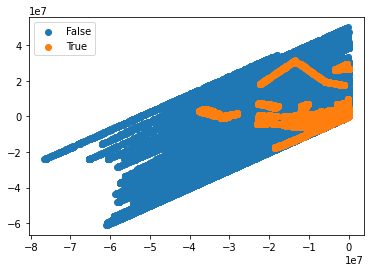

Counter({False: 1097538, True: 1097538})


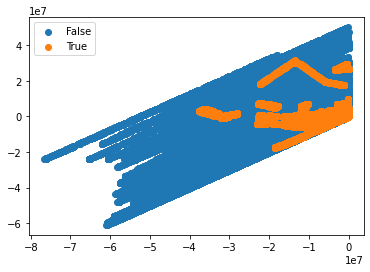

In [33]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Visualise class distribution before rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

# define pipeline
over = SMOTE()
under = RandomUnderSampler()
steps = [('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
modelsData_trainFeatures, modelsData_trainLabels = pipeline.fit_resample(modelsData_trainFeatures, modelsData_trainLabels)

#Visualise class distribution after rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

## 4.3 Modeling - Random Forest (OLD, only used for quick testing)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)

# Train the model on training data
rf.fit(modelsData_trainFeatures, modelsData_trainLabels.astype(bool));

#Display the model performance    
showModelPerformance(trainedModel = rf, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)


In [ ]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

import pandas as pd
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=[processedData_academyFeatureNames])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4.4 Modeling - XGBoost (OLD, only used for quick testing)

In [ ]:
import xgboost as xgb

# Instantiate xgboost
GXBoost = xgb.XGBClassifier(#scale_pos_weight=1,
                            learning_rate=0.17,
                            colsample_bytree = 0.4,
                            subsample = 1.0,
                            objective='binary:logistic',
                            n_estimators=750,
                            max_depth=12,
                            gamma=0.03,
                            n_jobs=-1
                           # seed=27
)



# Train the model on training data
GXBoost.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = GXBoost, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# OLD Model Pipeline - Light GBM

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Import the model we are using
import lightgbm as lgb

# Instantiate Light GBM
LightGBM_Model = lgb.LGBMClassifier(n_jobs=-1, n_estimators = 3400, max_depth = 25)                         

# Train the model on training data
LightGBM_Model.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = LightGBM_Model, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# Model - Pipeline for GXBoost

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb


start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(n_jobs=2)],
                                    #['under', RandomUnderSampler()],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

# define search space
space = dict()
space['classifier__n_estimators'] = [450, 500, 550, 600, 650, 700, 750, 800, 850, 900]
space['classifier__max_depth'] = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
space['classifier__subsample'] = [0.7, 0.8, 0.9, 1.0]
space['classifier__learning_rate'] = [0.17, 0.18, 0.19, 0.2]
space['classifier__colsample_bytree'] = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
space['classifier__gamma'] = [0.01, 0.02, 0.03, 0.04, 0.05]
spaceEmpty = dict()

GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=-1, 
                            cv = stratified_kfold)

optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedGXBoostModel.best_score_
test_score = optimizedGXBoostModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

In [55]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import fbeta_score, make_scorer
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

for i in range(2):

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    #['under', RandomUnderSampler()],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    space = dict()
    space['classifier__learning_rate'] = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
    space['classifier__max_depth'] = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    space['classifier__min_child_weight'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    space['classifier__gamma'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    space['classifier__colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    spaceEmpty = dict()

    GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring=fhalf_scorer, 
                            n_jobs=-1, 
                            cv = stratified_kfold)

    optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    
    cv_score = optimizedGXBoostModel.best_score_
    test_score = optimizedGXBoostModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)
    
    #feature importance
    importances = optimizedGXBoostModel.best_estimator_._final_estimator.feature_importances_
    for i,v in enumerate(importances):
        print(v)



    #Display the model performance    
    showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MemoryError: Unable to allocate 929. MiB for an array with shape (990029, 123) and data type float64

# Model - Pipeline for Random Forests

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


pipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy=0.1, n_jobs=2)],
                             ['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', RandomForestClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict() 
space['classifier__n_estimators'] = [1000, 1100, 1200, 1300, 1400]
space['classifier__max_depth'] = [9, 10, 11, 12, 14, 15, 16]
space['classifier__min_samples_split'] = [1, 2, 3]


search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedRFModel = search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedRFModel.best_score_
test_score = optimizedRFModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

In [57]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

for i in range(10):

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    pipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                              ['under', RandomUnderSampler()],
                                ['classifier', RandomForestClassifier(n_jobs=-1)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    spaceEmpty = dict() 

    search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=-1, 
                            cv = stratified_kfold)

    optimizedRFModel = search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    cv_score = optimizedRFModel.best_score_
    test_score = optimizedRFModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


    #Display the model performance    
    showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MemoryError: Unable to allocate 929. MiB for an array with shape (990029, 123) and data type float64

# Model - Pipeline for Light GBM

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb

ftwo_scorer = make_scorer(fbeta_score, beta=2)

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


LightGBMPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.1, n_jobs=2)],
                                    #['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict()
space['classifier__num_leaves'] = [60, 70, 80, 90, 100]
space['classifier__max_depth'] = [5, 6, 7, 8]
space['classifier__min_data_in_leaf'] = [250, 500, 750, 1000, 1250, 1500]


LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedLightGBMModel.best_score_
test_score = optimizedLightGBMModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 483.862 seconds
Cross-validation score: 0.2853769076420344
Test score: 0.2863726135615537
Best Hyperparameters: {}
5378809.207801819
15073121.641490936
1839663.1273479462
324.6940002441406
166711.5006828308
849186.7614612579
94092.64891433716
965063.2320137024
16263.47290802002
11982.390769958496
114957.61689376831
1280176.8301963806
1104734.112312317
0.0
371780.15030288696
0.0
436273.00270080566
369387.07975006104
201242.35593414307
27154.55234527588
123190.93633270264
355949.4993534088
44725.1346282959
17558.933227539062
687873.3490066528
1116845.122833252
1302693.3660354614
2934171.8769950867
726031.3843650818
1148045.6943244934
2187156.5075912476
271685.6115036011
698161.3783226013
253964.68434143066
215853.4767036438
0.0
0.0
0.0
2707101.528324127
99192.15347671509
17173187.963279724
182686.59783172607
68000.20748901367
2986786.3338394165
257301.5700531006
853.822380065918
1186007.2378845215
0.0
0.0
0.0
22066.864360809326
862133.8319740295
1179758.

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 528.790 seconds
Cross-validation score: 0.305537649340941
Test score: 0.29853235490326885
Best Hyperparameters: {}
6459511.278060913
7846005.941936493
7853545.026893616
402.6789855957031
1266282.6174545288
3174571.324531555
255055.23095703125
109813.38157653809
73606.93962860107
91409.35768890381
237003.2216949463
168374.4499282837
496007.816986084
0.0
136309.42833709717
0.0
802786.5224609375
2630021.082633972
210777.06680297852
114279.577293396
837736.4810409546
863978.2523880005
97226.34949493408
774935.9990386963
158746.8592224121
13980.499588012695
1123376.9872283936
2077736.6599998474
848757.8892440796
675702.5299911499
592457.6180114746
261781.92797851562
5461255.343139648
45705.3067779541
186237.90504455566
0.0
0.0
0.0
252385.1686630249
114192.90185546875
684331.3027801514
1436293.6345748901
102911.97930908203
73837.64945220947
1835711.3814620972
551238.6600265503
1998764.506477356
0.0
0.0
0.0
2534452.174407959
368727.70360565186
62535.714050292

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 594.650 seconds
Cross-validation score: 0.3040380242929371
Test score: 0.29556650246305416
Best Hyperparameters: {}
150734045.63941193
40521297.787353516
9368954.748020172
2499.3369140625
1601271.1864089966
36493511.53794098
263802.09506225586
2593999.9477767944
2742022.791191101
134084.5420074463
159057.23664093018
349036.04138946533
616917.3481750488
0.0
1285303.3171081543
0.0
334144.98403930664
11718639.394340515
4503926.247970581
1708471.4374923706
850843.3797988892
844883.431728363
19469.838897705078
111901.387550354
29466.287620544434
595719.4178085327
2513542.3529663086
137747.6344871521
1827509.7511672974
965890.7294845581
24970.74105834961
1339356.0603179932
663604.2111129761
6205.127456665039
105110690.61486053
0.0
0.0
0.0
2090702.6170578003
184991.78396606445
1993642.5289916992
49958293.104393005
195305.50011444092
66367.59248352051
3666363.6415100098
82012.4620513916
38682.28307342529
0.0
0.0
0.0
698875.1454849243
129227.09663391113
234430.

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 513.926 seconds
Cross-validation score: 0.2860638914681811
Test score: 0.28616852146263916
Best Hyperparameters: {}
1757494.1996612549
243088941.16639328
40675098.35983658
5300.726257324219
12801832.27829361
196838531.52861023
1738459.603111267
127459.00595855713
541366.3558883667
1843577.829940796
2112144.3296432495
37836373.39688873
1048147.9641265869
0.0
61807.12770462036
0.0
1385730.7665748596
107297588.16638565
2566988.1645622253
2510435.111152649
133246.66075134277
35816.37629318237
12230.297096252441
281013.4455795288
6407757.615585327
184266.17500305176
8004763.575489044
949816.3187713623
23251609.809379578
2123226.7517547607
1953512.1125488281
81371.30577087402
549515.7590866089
166291.64408111572
29201367.893924713
0.0
0.0
0.0
3291691.842754364
39662.37649536133
797899.8344497681
420233.6533355713
93566.762550354
671091.7451705933
47856.40721130371
511648.27001953125
246115.74349212646
0.0
0.0
0.0
544216.9586715698
1780937.2521896362
4000925.

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 511.249 seconds
Cross-validation score: 0.30993471654499666
Test score: 0.313202698361709
Best Hyperparameters: {}
66953325.31045723
7541277.842468262
1842665.2170143127
15929.841339111328
154122.18896102905
323705.269033432
543995.623003006
57777.726303100586
137209.12769317627
32185.08853340149
15015.481170654297
41887359.0605278
4344981.255210876
0.0
248853.24448013306
0.0
13684019.751220703
6123675.357139587
6174385.612714767
230368.9102230072
20394134.80259323
583222.4542388916
5871926.171989441
183933.69396972656
915705.8462238312
4820024.475883484
4724411.06344223
130662.06981658936
12850741.037921906
3560055.9060897827
37474.20640182495
31328.754634857178
2574034.5339164734
616028.4284286499
565137.9987297058
0.0
0.0
0.0
1886666.43592453
110597.31610870361
168887.10912513733
446750.29207611084
20470.172971725464
140821.5157814026
483442.6898422241
6751752.01158905
139722.21688461304
0.0
0.0
0.0
7282705.4864730835
1162315.1850738525
7822854.6843

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1135.750 seconds
Cross-validation score: 0.2809911855859668
Test score: 0.32321253672869726
Best Hyperparameters: {}
3784415.502685547
11113963.889162064
8944767.146072388
15928.026397705078
1543272.7043151855
170440.98909759521
2680081.8431243896
425100.3680114746
4431379.45337677
103652.99263763428
267476.19354248047
14869.968975067139
127472.64121246338
0.0
27169.299507141113
0.0
256547.77696228027
1932125.305065155
204592.99179077148
54014296.31385803
1695024.6155929565
1223892.3092956543
33869.56101989746
859693.1788978577
523632.54640197754
28528.129413604736
8922500.358421326
3774267.8285751343
4948992.236515045
116256.50508499146
4502.184982299805
283309.58600997925
120554.4285621643
3490.085319519043
32159.008644104004
0.0
0.0
0.0
1249158.9615516663
479786.2833709717
69868.43956375122
536654.1674385071
5061.940933227539
118622.56830215454
1586766.1696472168
4347.718017578125
49810.82676696777
0.0
0.0
0.0
79523.20359420776
23281.60646057129
373

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 589.264 seconds
Cross-validation score: 0.29499175493953994
Test score: 0.33376330216059336
Best Hyperparameters: {}
5976980.28053093
1077881.138053894
6537479.671207428
1158.5549716949463
265055.5743713379
8338738.857307434
123154.15673065186
162421.65047454834
10090.291187286377
2693804.564453125
68743.86901664734
3256708.938270569
12079.550743103027
0.0
31554968.63572693
0.0
50432.48215484619
73464.75259399414
17433296.110567093
11409.674697875977
2092876.736919403
240300.13386535645
150982.16771697998
231748.6746559143
16425.346508026123
2289534.2817077637
5654118.58420372
942817.4836616516
128689.89498710632
1813989.3030910492
305870.7799987793
1989621.6694984436
144113.02514266968
276697.7708930969
95579.1039276123
0.0
0.0
0.0
81217.11580657959
629615.3658714294
1705168.2844333649
77908.20861434937
3038.094528198242
157178.55809020996
84482.48707580566
4265.746593475342
16323.049886703491
0.0
0.0
0.0
181549.36632156372
804687.234298706
445304.976

C:\Python39\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 557.726 seconds
Cross-validation score: 0.298506801132249
Test score: 0.3309768637532134
Best Hyperparameters: {}
3629026.3051567078
90507402.85741425
9342465.427307129
1992.1195602416992
1294348.566482544
1344160.6093597412
420897.0279083252
1854638.615600586
152968.46646881104
17200661.79725647
410391.58684539795
653960.0039672852
44634368.511032104
0.0
3823334.8455352783
0.0
1679391.0893478394
649091.7180252075
9611076.471225739
5866837.444450378
392610.6762237549
164300.69232177734
540644.9612426758
216195.8041152954
301438.3001937866
839596.3998413086
1038369.4242782593
2461885.9318847656
1193761.2047805786
1259362.232498169
33219.70799255371
1701388.2145462036
270197.104347229
393887.88681030273
521880.32092285156
0.0
0.0
0.0
485763.4581680298
163857.0022277832
6226405.303970337
200336.51076507568
1265448.0852279663
5911216.00592041
2825188.840232849
16847.327087402344
3414235.4928131104
0.0
0.0
0.0
120795.35325622559
209310.56409454346
478235.63

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 605.350 seconds
Cross-validation score: 0.2910773537264747
Test score: 0.2804182509505704
Best Hyperparameters: {}
93280377.7005539
27576238.49122238
33748200.73313141
851.2359771728516
1778237.198234558
2153952.5890808105
125881.38535308838
215255.25875854492
159637.76063537598
1231832.7208709717
68942.9268875122
14434221.040657043
486491.85262298584
0.0
144858.10014343262
0.0
560424.763343811
20048914.726524353
4777858.903488159
97802.49493408203
18234885.03514099
54052.60355377197
1152604.7340698242
91659.6134262085
75044.34240722656
2716557.1852111816
1209466.1114273071
241107.5319480896
39649056.83507538
1938342.0670318604
29789.77133178711
125380.49272155762
128598.85565948486
19034.691864013672
258596.70973205566
0.0
0.0
0.0
11536997.717254639
120776.24209594727
5891097.371704102
264107.06845092773
1360778.8946533203
397958.50762176514
573661.0388412476
2870.892074584961
229331.4003753662
0.0
0.0
0.0
126207.50271606445
767537.1046333313
111854.3

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 703.915 seconds
Cross-validation score: 0.28990620352466734
Test score: 0.3059210526315789
Best Hyperparameters: {}
12830014.653905869
8910002.16718483
3945377.3861522675
14802.514009475708
5453829.357322693
7764688.801994324
61861.39597320557
196235.6888885498
11528.042945861816
72495.53540039062
13303.684566497803
11532654.36737442
912713.4056549072
0.0
149541.0757713318
0.0
1109455.5313529968
2759426.7980804443
187137.47520065308
68870.83089065552
39085.292167663574
13742.74271774292
332990.4511642456
13031.936563491821
393500.0156364441
9880.03268814087
307804.73174858093
609947.3213195801
186292.33326339722
347304.3076324463
138767.11909484863
672557.7011108398
2582863.1501903534
1394.6943817138672
320630.18184661865
0.0
0.0
0.0
38111.97987365723
74518.65041351318
1207710.3930664062
151335.0900592804
52034.99702453613
36540.662826538086
1178087.875919342
33182.26111602783
171962.44528198242
0.0
0.0
0.0
31498686.296531677
446499.915309906
823704.43

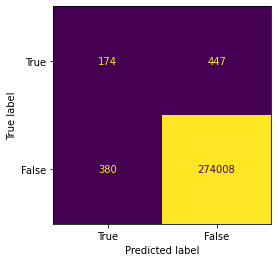

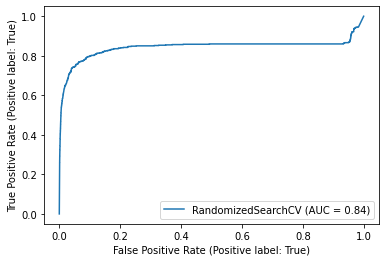

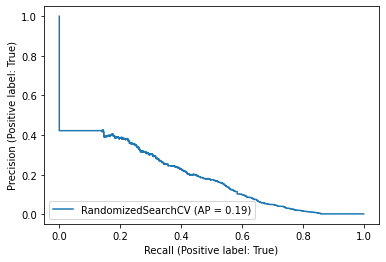

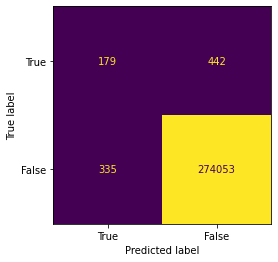

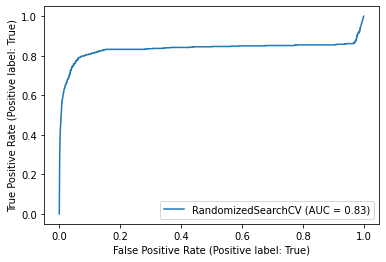

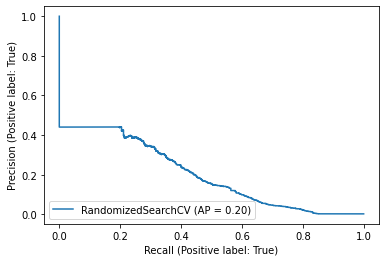

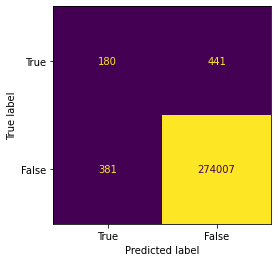

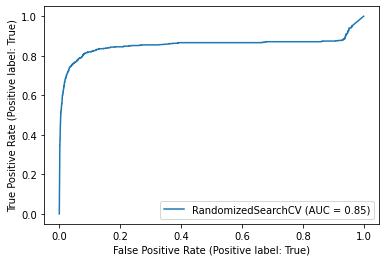

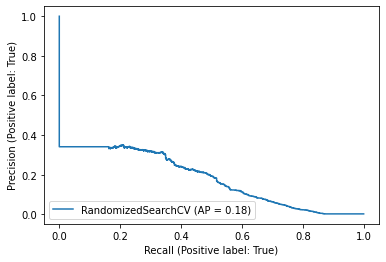

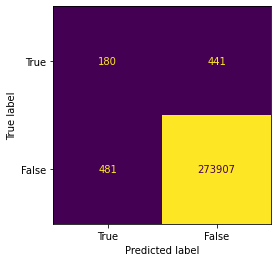

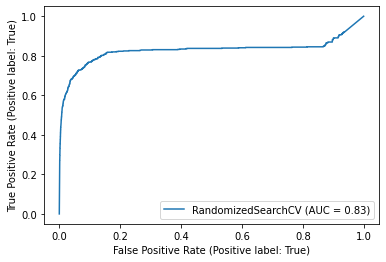

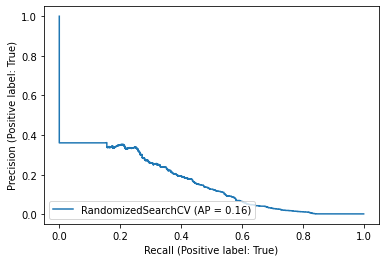

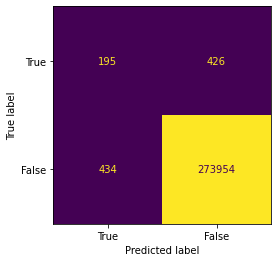

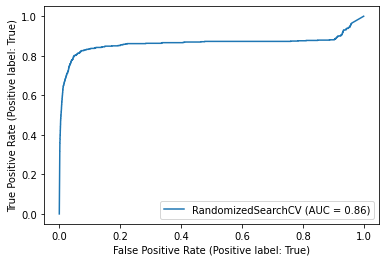

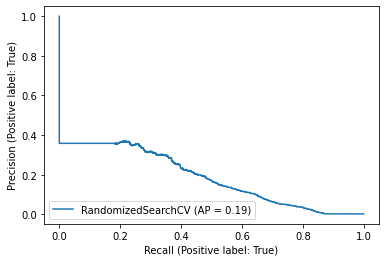

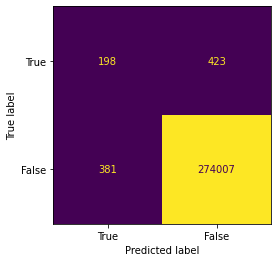

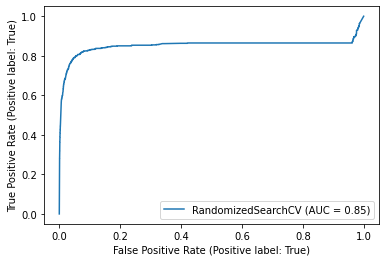

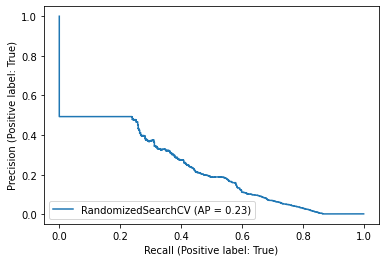

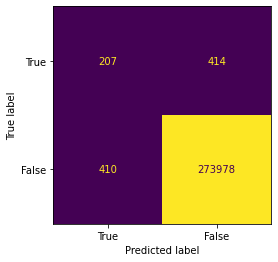

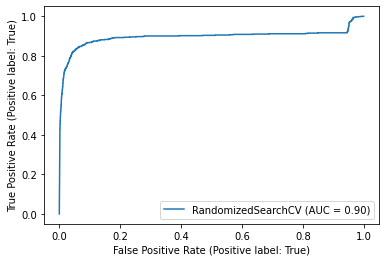

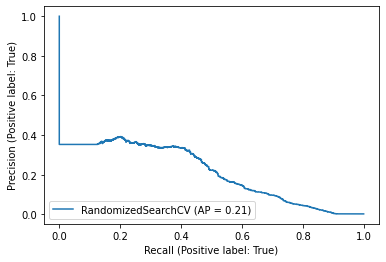

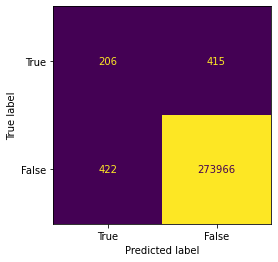

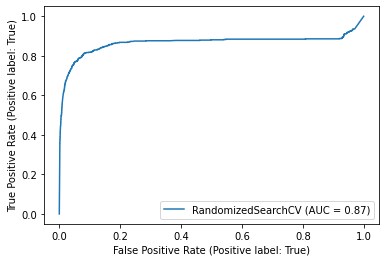

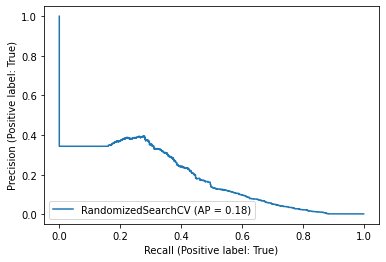

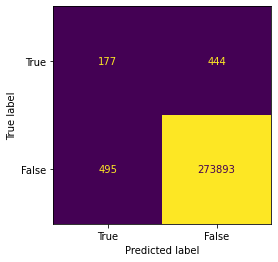

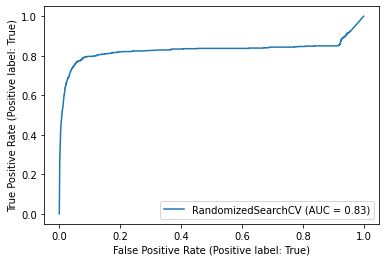

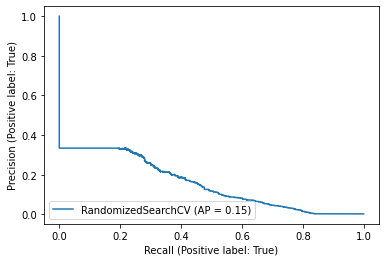

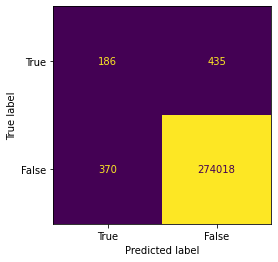

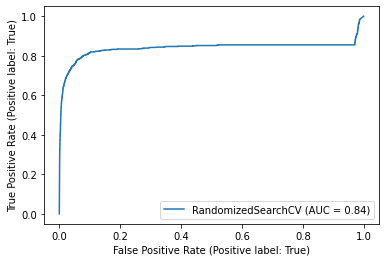

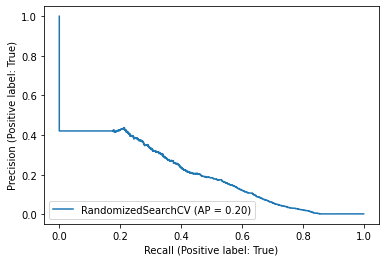

In [41]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb

for i in range(10):

    ftwo_scorer = make_scorer(fbeta_score, beta=2)

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    LightGBMPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    #['under', RandomUnderSampler()],
                                ['classifier', lgb.LGBMClassifier(n_jobs=-1, importance_type='gain')]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

# define search space
    # define search space
    space = dict()
    spaceEmpty = dict()
    space['classifier__num_leaves'] = [11, 16, 21, 26, 31, 36, 41, 46, 51, 56]
    space['classifier__min_data_in_leaf'] =  [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__max_depth'] = [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__learning_rate'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]
    space['classifier__max_bin'] = [50, 100, 150, 200, 255, 300, 350, 400, 450, 500]

    LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=-1, 
                            cv = stratified_kfold)

    optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    cv_score = optimizedLightGBMModel.best_score_
    test_score = optimizedLightGBMModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)
    
    #feature importance
    importances = optimizedLightGBMModel.best_estimator_._final_estimator.booster_.feature_importance(importance_type='gain')
    for i,v in enumerate(importances):
        print(v)


    #Display the model performance    
    showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)